In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import metpy
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import os

from model_collection import ModelCollection
from plotting import grouped_boxplot_with_table

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

#https://stackoverflow.com/a/64823806/5217293
import joblib

from tqdm.notebook import tqdm

from IPython.display import HTML, display
from matplotlib import animation
import cartopy.feature as cfeature
import matplotlib 
import matplotlib.cm as cm
import string
matplotlib.rcParams['animation.embed_limit'] = 2**128

save_path = 'figures_and_data/'

In [2]:
df = pd.read_csv('data/matched/all_years_months.csv', parse_dates=['time'])

In [3]:
# df = df.dropna()

In [4]:
X, y = df.drop(columns=['PM25', 'time', 'n_snapshots'], axis=1), df['PM25']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [6]:
groups = X_train['lat'].astype(str) + ',' + X_train['lon'].astype(str)

In [7]:
X_train = X_train.to_numpy(dtype='float', na_value=np.nan)
y_train = y_train.to_numpy(dtype='float', na_value=np.nan)
X_test = X_test.to_numpy(dtype='float', na_value=np.nan)
y_test = y_test.to_numpy(dtype='float', na_value=np.nan)

In [8]:
gkf = list(GroupKFold(10).split(X_train, y_train, groups=groups))

In [9]:
mc = ModelCollection(X_train, y_train, cv=10)

# Hyperparameters

In [10]:
mc.tune_hyperparameters()

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/test/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'Random Forest': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('random_forest',
                                         RandomForestRegressor())]),
              n_jobs=4,
              param_grid={'random_forest__max_depth': [20, 30, 40],
                          'random_forest__max_features': [4],
                          'random_forest__min_samples_leaf': [1],
                          'random_forest__min_samples_split': [2],
                          'random_forest__n_estimators': [200, 300, 400, 500]}),
 'Extra Trees': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('extra_trees', ExtraTreesRegressor())]),
              n_jobs=4,
              param_grid={'extra_trees__max_depth': [20, 30, 40, 50],
                          'extra_trees__max_features': [4],
                          'extra_trees__min_samples_leaf': [1],
                          'extra_trees__min_samples_split': [2],
                          'extra_trees__n_estimators': [200, 300, 

In [14]:
mc.hyperparameters_['Extra Trees'].cv_results_['mean_test_score']

array([0.6154521 , 0.61636703, 0.61536647, 0.61663587, 0.71954849,
       0.72043948, 0.71990144, 0.72018769, 0.7329304 , 0.73345042,
       0.73290528, 0.7336184 , 0.73229307, 0.73416331, 0.73372298,
       0.73375705])

In [11]:
mc.hyperparameters_['Extra Trees'].best_params_

{'extra_trees__max_depth': 50,
 'extra_trees__max_features': 4,
 'extra_trees__min_samples_leaf': 1,
 'extra_trees__min_samples_split': 2,
 'extra_trees__n_estimators': 300}

In [12]:
mc.hyperparameters_['Random Forest'].best_params_

{'random_forest__max_depth': 40,
 'random_forest__max_features': 4,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__n_estimators': 300}

In [22]:
joblib.dump(mc.hyperparameters_, os.path.join(save_path, 'hyperparameters.pcl'))

['figures and data/hyperparameters.pcl']

In [16]:
old = mc.hyperparameters_.copy()

In [18]:
mc.hyperparameters_.update(old)

In [21]:
mc.hyperparameters_['Extra Trees'].best_params_

{'extra_trees__max_depth': 50,
 'extra_trees__max_features': 4,
 'extra_trees__min_samples_leaf': 1,
 'extra_trees__min_samples_split': 2,
 'extra_trees__n_estimators': 300}

In [10]:
mc.hyperparameters_ = joblib.load(os.path.join(save_path, 'hyperparameters.pcl'))

In [11]:
mc.update_models_from_hyperparamters()

In [101]:
mc.hyperparameters_['Bayesian Ridge'].best_estimator_.get_params()

{'memory': None,
 'steps': [('bayesian_ridge', BayesianRidge(alpha_1=0.0001, lambda_2=0.0001))],
 'verbose': False,
 'bayesian_ridge': BayesianRidge(alpha_1=0.0001, lambda_2=0.0001),
 'bayesian_ridge__alpha_1': 0.0001,
 'bayesian_ridge__alpha_2': 1e-06,
 'bayesian_ridge__alpha_init': None,
 'bayesian_ridge__compute_score': False,
 'bayesian_ridge__copy_X': True,
 'bayesian_ridge__fit_intercept': True,
 'bayesian_ridge__lambda_1': 1e-06,
 'bayesian_ridge__lambda_2': 0.0001,
 'bayesian_ridge__lambda_init': None,
 'bayesian_ridge__n_iter': 300,
 'bayesian_ridge__normalize': 'deprecated',
 'bayesian_ridge__tol': 0.001,
 'bayesian_ridge__verbose': False}

In [29]:
mc.models['Extra Trees'].named_steps['extra_trees'].get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# CV

In [12]:
mc.compute_cross_validation_scores();

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/test/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [13]:
mc.save_model_cross_val_scores(os.path.join(save_path, 'cv-all_years.pcl'))

In [132]:
mc.load_model_cross_val_scores('data/model_runs/tuned-all_years_months-cv.pcl')

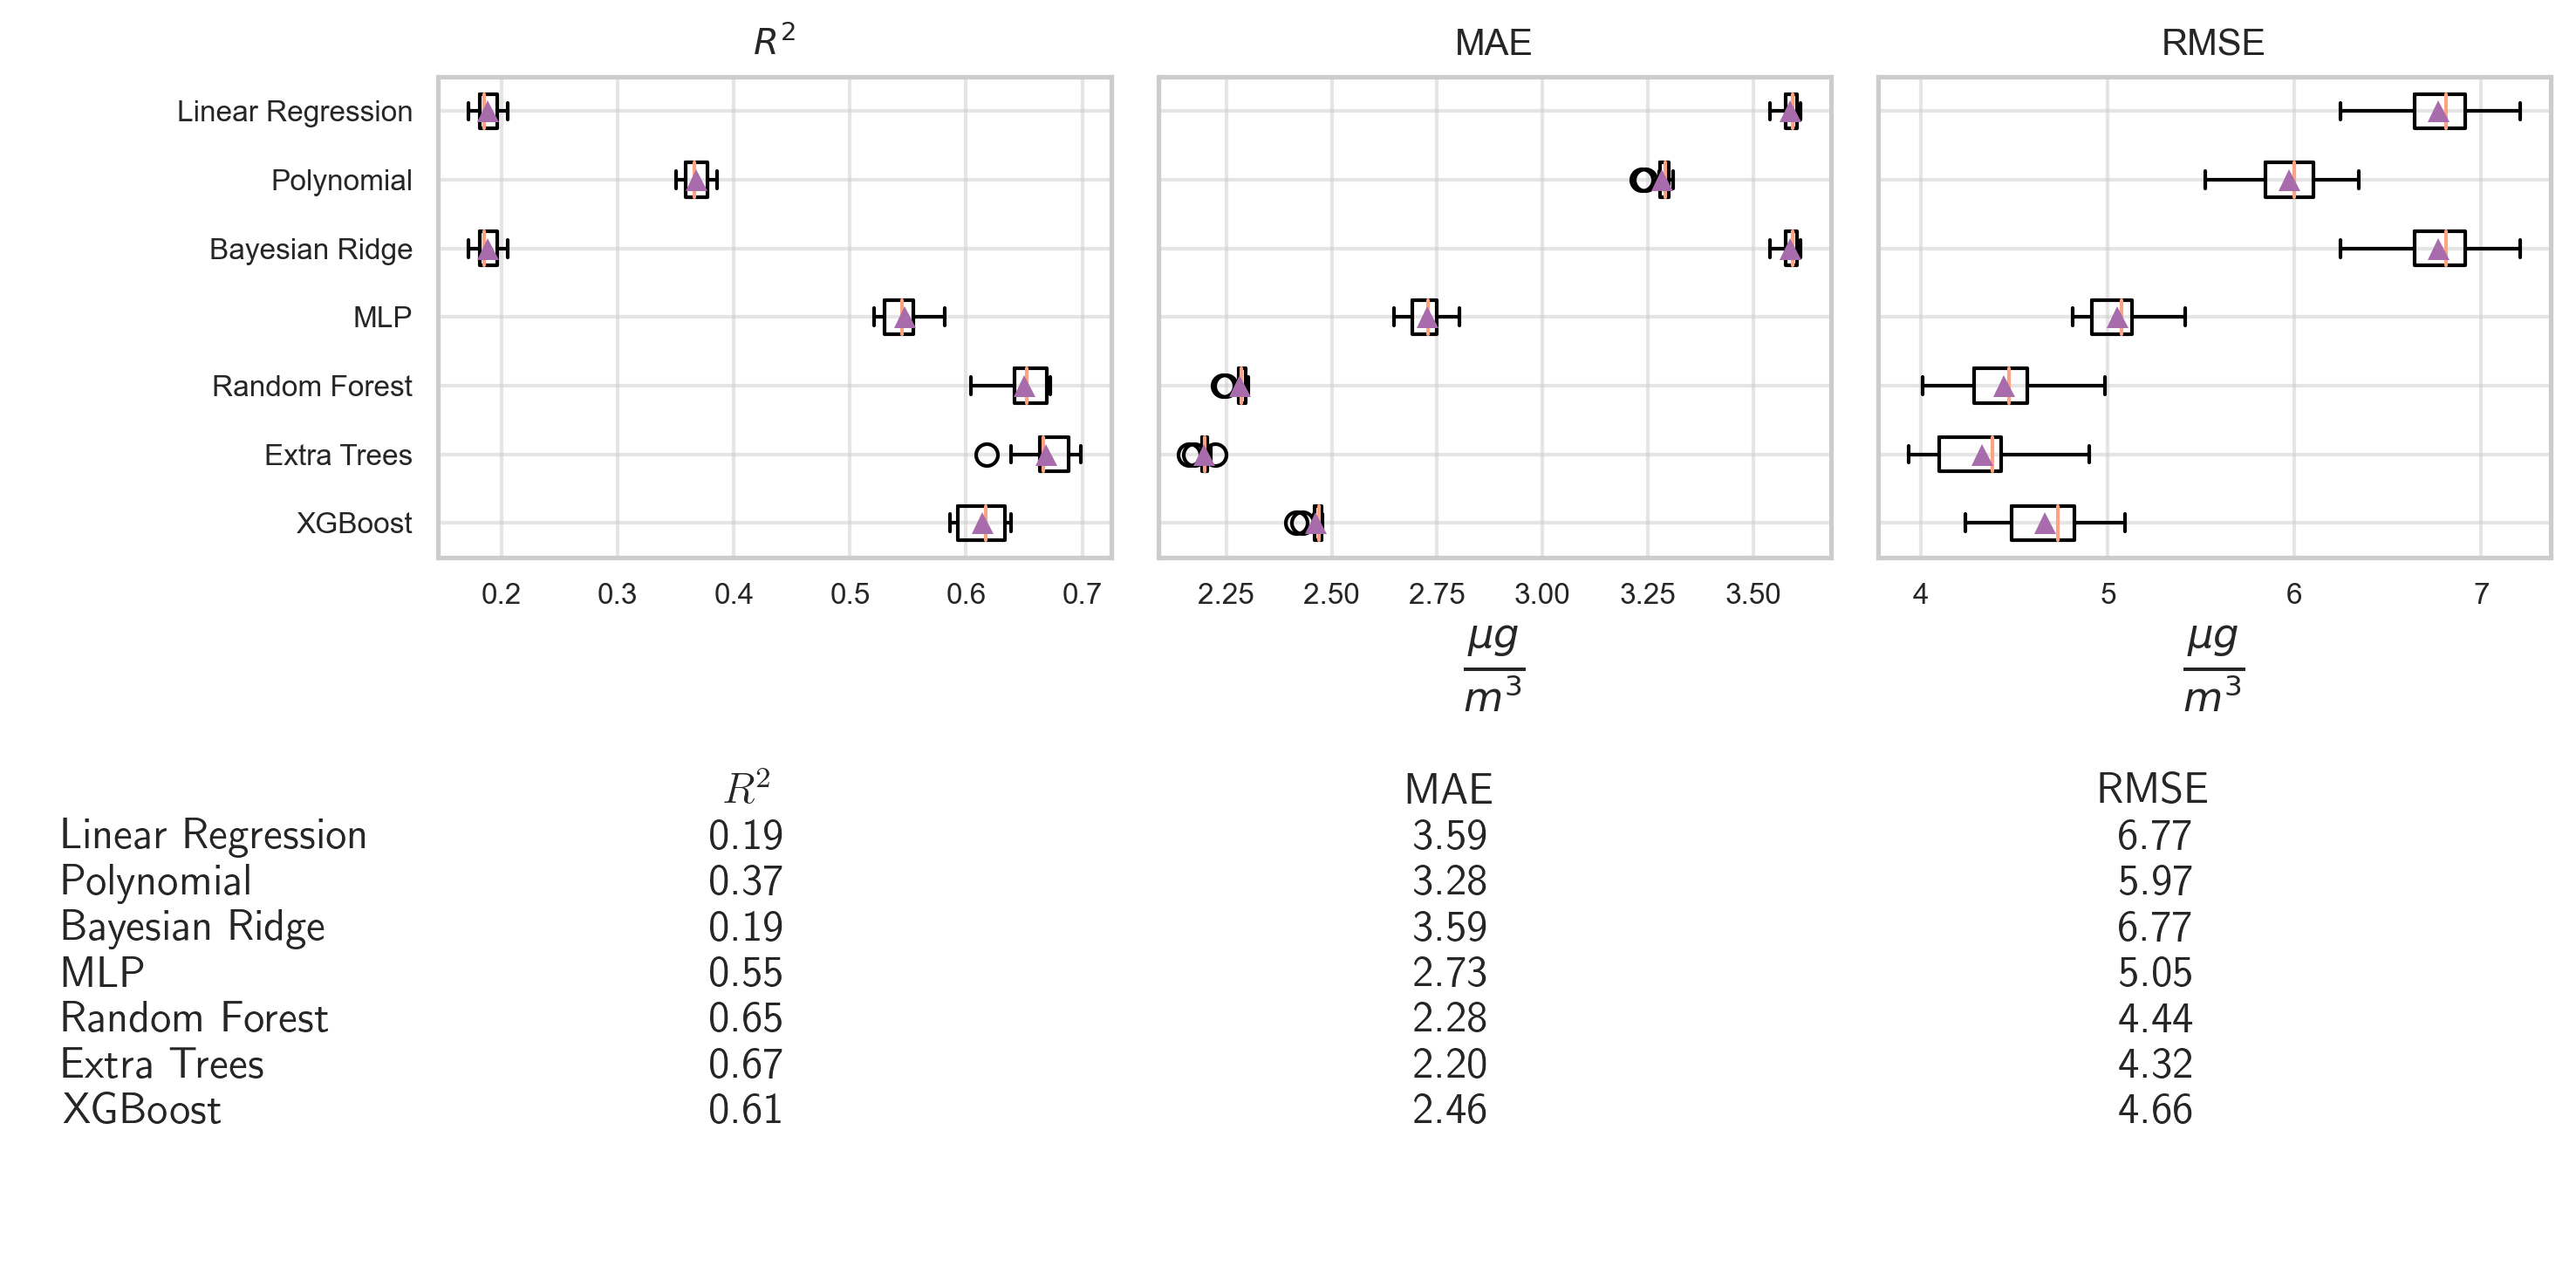

In [14]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=False, fs=8);

# Fit

In [15]:
mc.fit()

  0%|          | 0/7 [00:00<?, ?it/s]

{'Linear Regression': 0.5687370300292969,
 'Polynomial': 14.887000799179077,
 'Bayesian Ridge': 0.5642349720001221,
 'MLP': 156.91536903381348,
 'Random Forest': 418.72970700263977,
 'Extra Trees': 215.0123748779297,
 'XGBoost': 149.6635241508484}

In [16]:
mc.save(os.path.join(save_path, 'trained-models-all_years.pcl'))

In [4]:
mc = ModelCollection.__new__(ModelCollection)

In [5]:
mc.load(os.path.join(save_path, 'trained-models-all_years.pcl'))

In [7]:
mc.models['Extra Trees'].named_steps['extra_trees'].get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [8]:
mc.models['Random Forest'].named_steps['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [17]:
scores = pd.DataFrame(mc.compute_scores(X_test, y_test)).T

In [18]:
scores.to_csv(f'{save_path}/test-scores-all_years.csv')
scores

,r2,rmse,mae
Linear Regression,0.181898,7.011791,3.626260
Polynomial,0.360593,6.198891,3.320444
Bayesian Ridge,0.181896,7.011802,3.626211
MLP,0.572578,5.068202,2.737496
Random Forest,0.649086,4.592250,2.284320
Extra Trees,0.668471,4.463610,2.190452
XGBoost,0.606741,4.861439,2.480085


In [20]:
predictions = pd.DataFrame(mc.predict(X_test))

In [21]:
predictions['True'] = y_test

In [22]:
predictions.to_csv(f'{save_path}/predictions-all_years.csv')

In [23]:
# predictions = pd.read_csv(f'{save_path}/predictions.csv', index_col=0)

In [24]:
predictions

,Linear Regression,Polynomial,Bayesian Ridge,MLP,Random Forest,Extra Trees,XGBoost,True
0,11.135962,14.313296,11.134620,17.775552,17.807701,17.643686,15.452457,19.417500
1,7.152531,5.581973,7.152632,4.401187,5.419335,5.616024,4.715158,8.086111
2,11.344683,12.525351,11.342102,15.545159,14.614941,14.881966,15.797239,12.736809
3,10.267984,8.512911,10.265225,5.796468,6.137704,5.964870,6.109481,6.141666
4,7.776732,6.391999,7.775651,6.377154,5.070378,4.848021,4.710777,5.225000
...,...,...,...,...,...,...,...,...
118991,2.537109,7.206110,2.533370,4.670802,4.511635,4.213118,3.044520,2.010416
118992,10.301421,7.822657,10.301964,6.309837,7.256891,8.117388,6.043123,8.704166
118993,6.085584,11.346386,6.084416,10.566024,8.900418,10.003772,10.171474,10.816667
118994,8.897627,7.919712,8.897113,10.183806,9.575985,9.206764,9.366104,4.700000


# Figures

In [25]:
months = {
    'month_1':'Jan.', 
    'month_2':'Feb.',
    'month_3':'Mar.', 
    'month_4':'Apr.', 
    'month_5':'May', 
    'month_6':'Jun.', 
    'month_7':'Jul.', 
    'month_8':'Aug.',
    'month_9':'Sept.', 
    'month_10':'Oct.', 
    'month_11':'Nov.', 
    'month_12':'Dec.',
}

In [26]:
# https://stackoverflow.com/a/49601444/5217293

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [27]:
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## CV Plots and tables

In [28]:
from plotting import score_boxplot
from utils import summarize_scores

In [2]:
mc = ModelCollection.__new__(ModelCollection)

### Cross validation

In [3]:
mc.load_model_cross_val_scores('data/model_runs/tuned-all_years_months-cv.pcl')

In [29]:
index, r2, mae, rmse = [], [], [], []
for key, vals in mc.cross_val_scores_.items():
    index.append(key)
    s = summarize_scores(vals)
    r2.append(s[0])
    mae.append(s[1])
    rmse.append(s[2])

In [30]:
cvscores = pd.DataFrame({'R2': r2, 'MAE': mae, 'RMSE': rmse}, index=index)
cvscores.to_csv(f'{save_path}/cv-scores-all_years.csv')
cvscores

,R2,MAE,RMSE
Linear Regression,0.187951,3.586483,6.766692
Polynomial,0.367761,3.283223,5.970443
Bayesian Ridge,0.187950,3.586387,6.766694
MLP,0.547005,2.725907,5.050454
Random Forest,0.650334,2.281230,4.440512
Extra Trees,0.668459,2.196693,4.323136
XGBoost,0.614286,2.461213,4.663312


In [6]:
cvscores = pd.read_csv(f'{save_path}/cv-scores.csv', index_col=0)

In [31]:
labels, the_scores = map(list, zip(*mc.cross_val_scores_.items()))

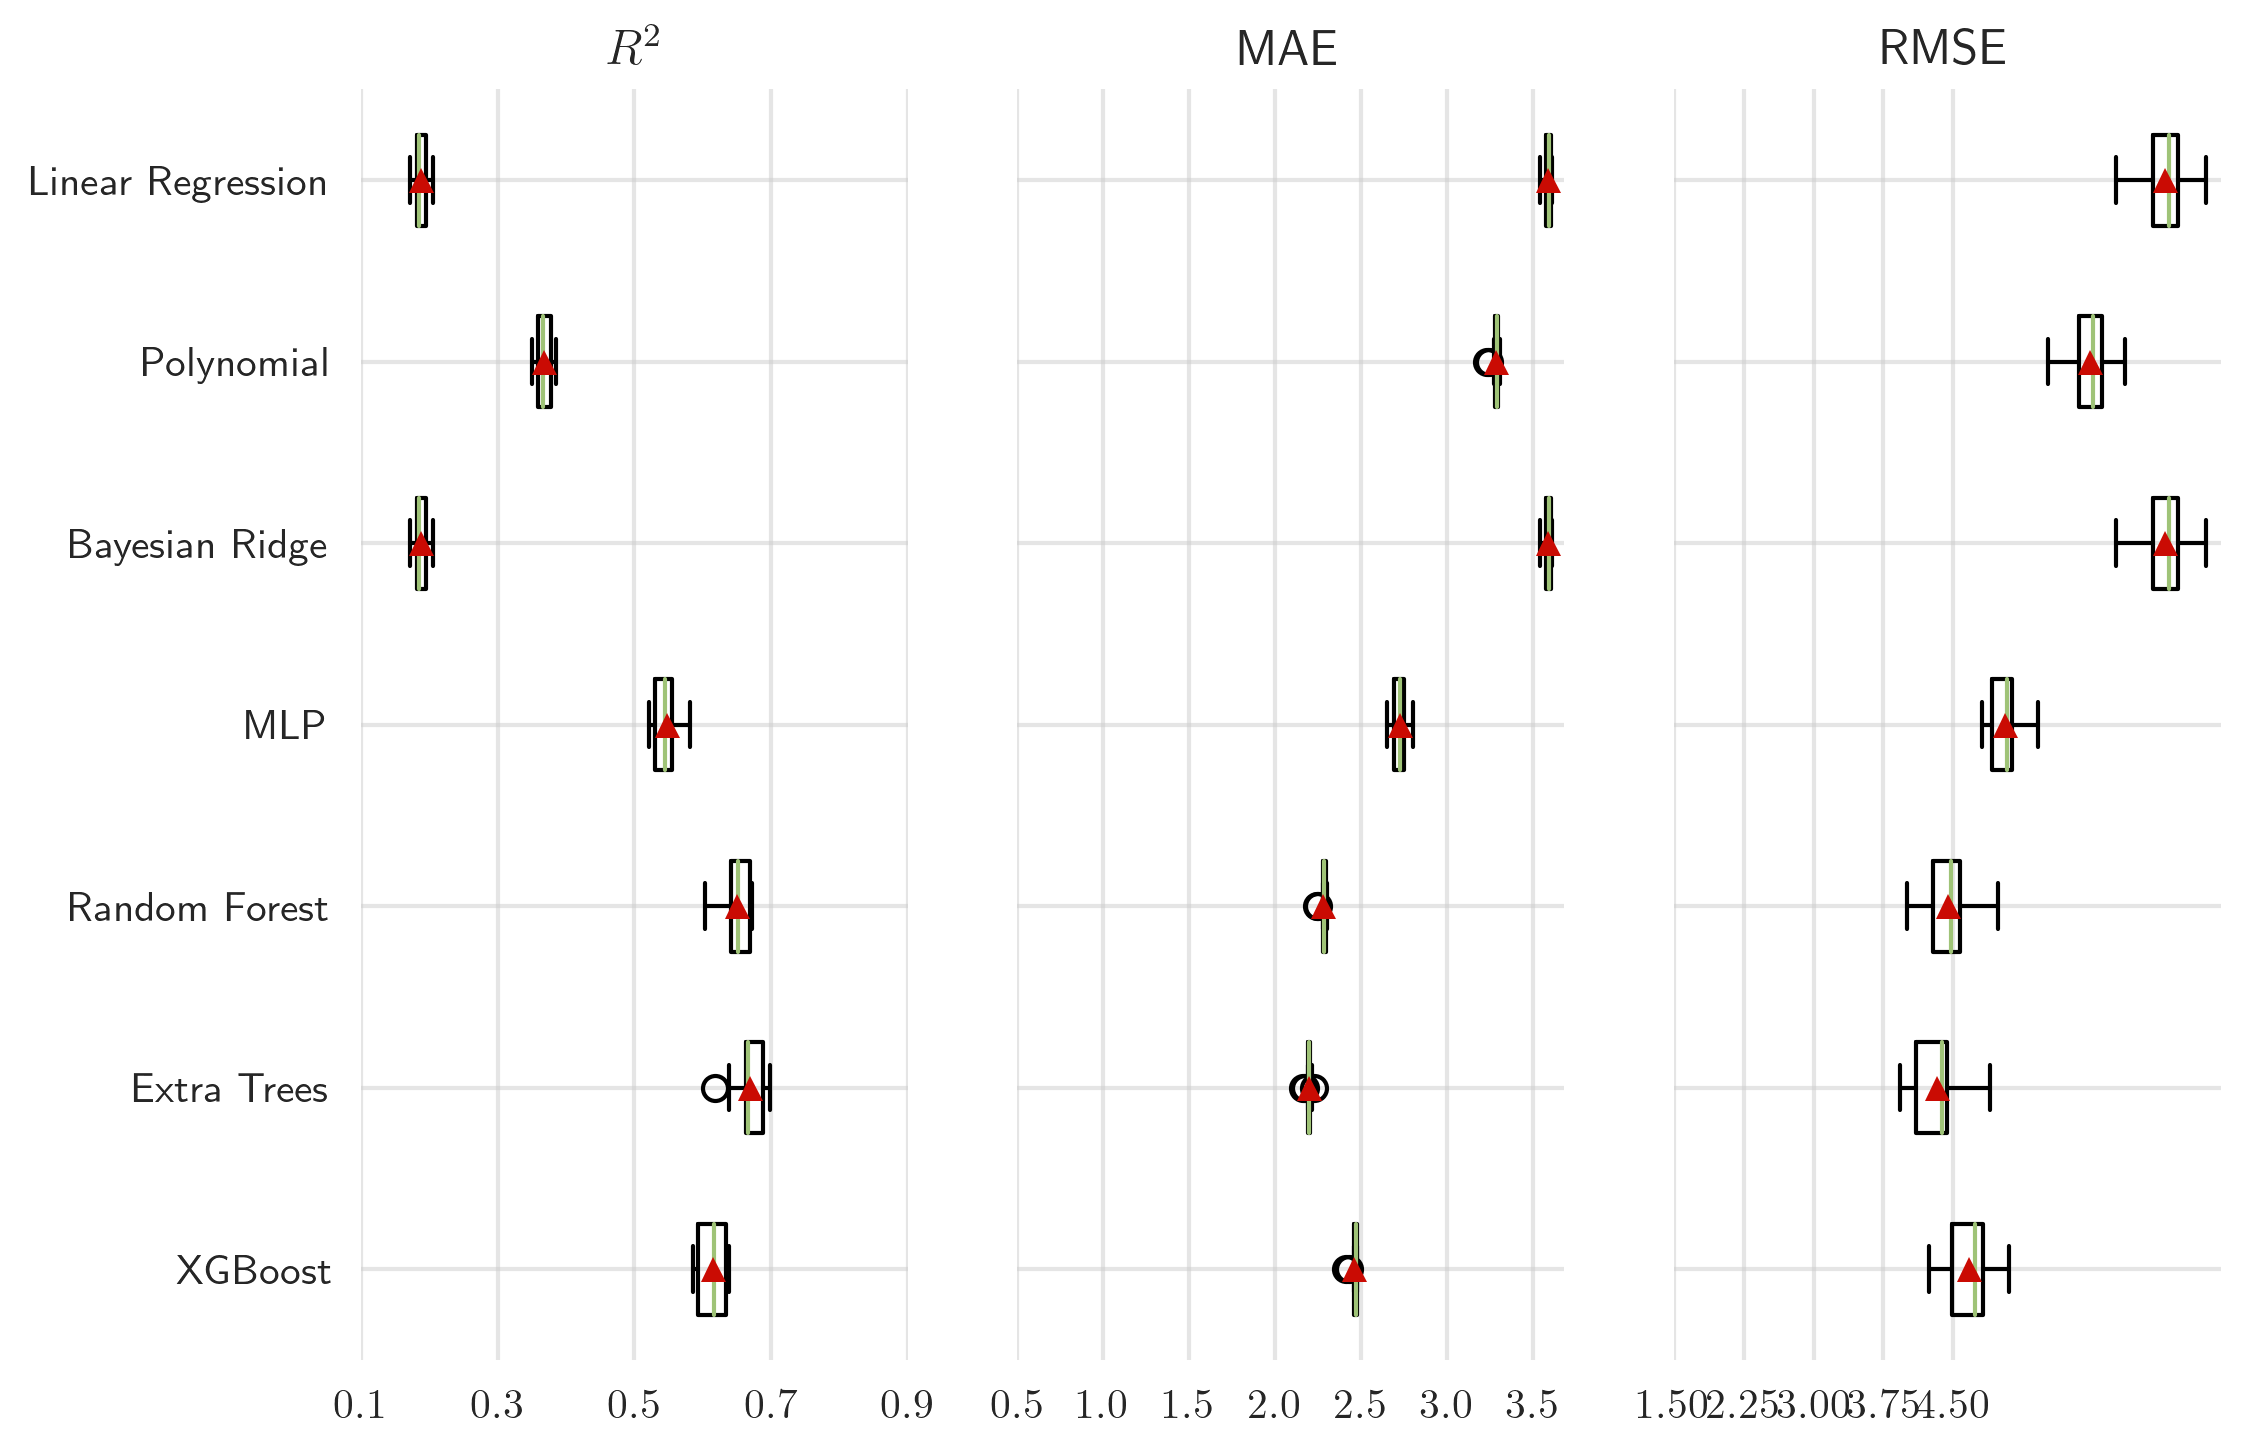

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300)

score_boxplot('test_r2', *the_scores, ax=ax1, labels=labels)
score_boxplot('test_neg_mean_absolute_error', *the_scores, ax=ax2, labels=labels, take_absolute_value=True)
score_boxplot('test_neg_root_mean_squared_error', *the_scores, ax=ax3, labels=labels, take_absolute_value=True)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax1.set_title('$R^2$')
ax2.set_title('MAE')
ax3.set_title('RMSE')

for ax in [ax1, ax2, ax3]:
    ax.spines[:].set_visible(False)

ax2.set_yticklabels([])
ax3.set_yticklabels([]);

ax1.set_xticks(np.arange(0.1, 1, 0.2))
ax2.set_xticks(np.arange(0.5, 3.6, 0.5))
ax3.set_xticks(np.arange(1.5, 5.1, 0.75))

fig.savefig(f'{save_path}/cv-boxplots-all_years.png', format='png', bbox_inches = "tight")

### Regional CV

In [22]:
mc.load_model_cross_val_scores('data/model_runs/tuned-all_years_months-site-based-cv.pcl')

In [32]:
index, r2, mae, rmse = [], [], [], []
for key, vals in mc.cross_val_scores_.items():
    index.append(key)
    s = summarize_scores(vals)
    r2.append(s[0])
    mae.append(s[1])
    rmse.append(s[2])

In [147]:
regional_cv = pd.DataFrame({'R2': r2, 'MAE': mae, 'RMSE': rmse}, index=index)
regional_cv.to_csv(f'{save_path}/regional-cv-scores.csv')
regional_cv

,R2,MAE,RMSE
Linear Regression,0.168529,3.105595,4.743737
Polynomial,0.275721,2.882423,4.428236
Bayesian Ridge,0.168529,3.105575,4.743737
MLP,0.431326,2.537806,3.924205
Random Forest,0.464432,2.388042,3.796682
Extra Trees,0.561734,2.197366,3.442844
XGBoost,0.374016,2.713048,4.111098


In [33]:
regional_cv = pd.read_csv(f'{save_path}/regional-cv-scores.csv', index_col=0)

In [34]:
b = regional_cv.astype(str)

In [35]:
for idx, vals in regional_cv.iterrows():
    for col in ['R2','MAE','RMSE']:
        percent_decrease = ((cvscores.loc[idx][col] - vals[col]) / cvscores.loc[idx][col]) * 100
        b.loc[idx][col] = f'{vals[col]:.2f} ({percent_decrease:.2f}%)'
    

In [36]:
b

,R2,MAE,RMSE
Linear Regression,0.17 (2.57%),3.11 (-0.31%),4.74 (-0.01%)
Polynomial,0.28 (5.42%),2.88 (-1.25%),4.43 (-0.87%)
Bayesian Ridge,0.17 (2.57%),3.11 (-0.31%),4.74 (-0.01%)
MLP,0.43 (19.98%),2.54 (-8.22%),3.92 (-10.83%)
Random Forest,0.46 (44.32%),2.39 (-93.04%),3.80 (-78.80%)
Extra Trees,0.56 (35.61%),2.20 (-160.83%),3.44 (-84.81%)
XGBoost,0.37 (45.87%),2.71 (-37.26%),4.11 (-41.83%)


In [53]:
b.to_csv(f'{save_path}/regional-cv-scores-percent-decrease.csv')

In [24]:
labels, the_scores = map(list, zip(*mc.cross_val_scores_.items()))

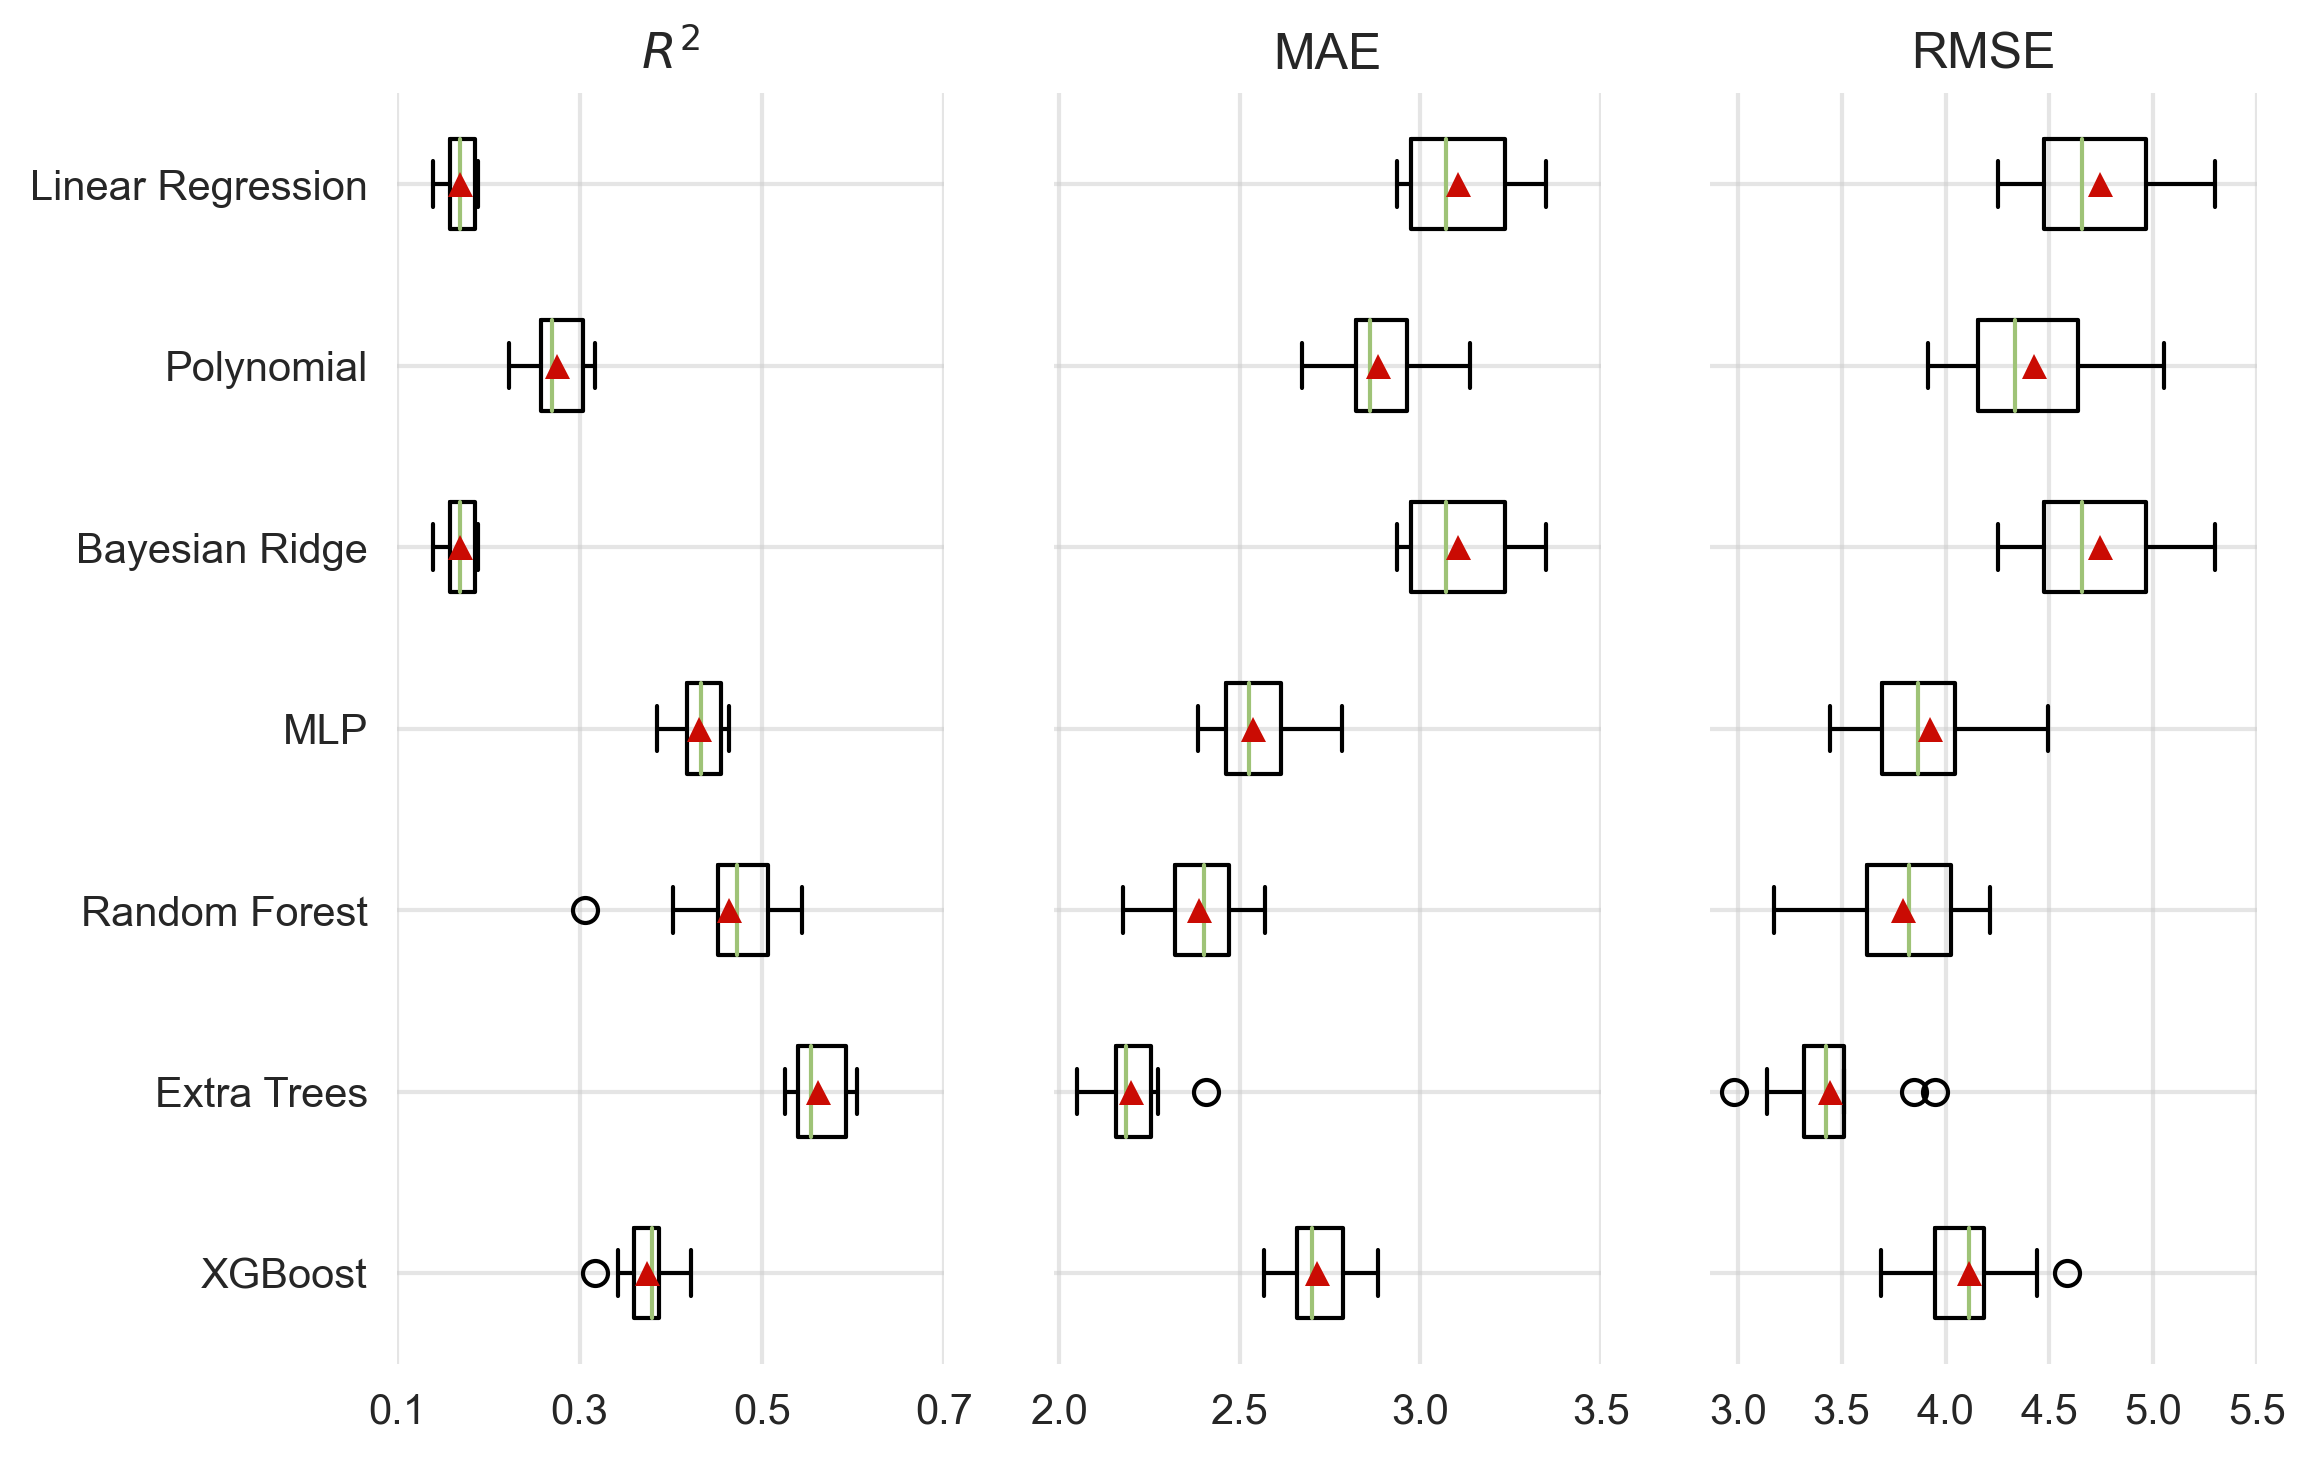

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300)

score_boxplot('test_r2', *the_scores, ax=ax1, labels=labels)
score_boxplot('test_neg_mean_absolute_error', *the_scores, ax=ax2, labels=labels, take_absolute_value=True)
score_boxplot('test_neg_root_mean_squared_error', *the_scores, ax=ax3, labels=labels, take_absolute_value=True)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax1.set_title('$R^2$')
ax2.set_title('MAE')
ax3.set_title('RMSE')

ax1.set_xticks(np.arange(0.1, 0.71, 0.2))
ax2.set_xticks(np.arange(2, 3.6, 0.5))
ax3.set_xticks(np.arange(3, 5.6, 0.5))

ax2.set_yticklabels([])
ax3.set_yticklabels([]);
for ax in [ax1, ax2, ax3]:
    ax.spines[:].set_visible(False)

fig.savefig(f'{save_path}/cv-boxplots-regional.png', format='png', bbox_inches = "tight")

## Prediction Accuracy on out-of-sample data

In [33]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from scipy.stats import gaussian_kde

In [34]:
nn_color = "#FCA481"
tree_color = "#6549DA"
linear_color = "#6CB0F2"

colors = [linear_color] * 3 + [nn_color] * 1 + [tree_color] * 3 + ['#FDCB66']

Bins are from the [AQI Breakpoints for particulates](https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [35]:
bins = [0.0, 12.1, 35.5, 55.5, 150.5, 250.5, 350.5, 500.5, 99999.9]
cat = ['GOOD', 'MODERATE', 'UNHEALTHY FOR SENSITIVE', 'UNHEALTHY', 'VERY UNHEALTHY', 'HAZARDOUS', 'HAZARDOUS', 'HAZARDOUS']
index = [f'{a}-{b-.1:.1f} ({c})' for a, b, c in zip(bins[0:-1], bins[1:], cat)]

In [36]:
epa = pd.DataFrame({a : np.histogram(predictions[a], bins=bins)[0] for a in predictions.columns}, index=index)
total = len(predictions)
fmt = lambda x: f'{x} ({np.round(x/total*100, 1)} %)'
epa = epa.applymap(fmt).T
epa.to_csv(f'{save_path}/epa_categories-all_years.csv')
epa

,0.0-12.0 (GOOD),12.1-35.4 (MODERATE),35.5-55.4 (UNHEALTHY FOR SENSITIVE),55.5-150.4 (UNHEALTHY),150.5-250.4 (VERY UNHEALTHY),250.5-350.4 (HAZARDOUS),350.5-500.4 (HAZARDOUS),500.5-99999.8 (HAZARDOUS)
Linear Regression,106566 (89.6 %),12083 (10.2 %),52 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
Polynomial,105055 (88.3 %),13064 (11.0 %),327 (0.3 %),95 (0.1 %),0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
Bayesian Ridge,106564 (89.6 %),12087 (10.2 %),52 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
MLP,104977 (88.2 %),13367 (11.2 %),424 (0.4 %),214 (0.2 %),11 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
Random Forest,104499 (87.8 %),13921 (11.7 %),357 (0.3 %),217 (0.2 %),2 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
Extra Trees,104312 (87.7 %),14113 (11.9 %),369 (0.3 %),197 (0.2 %),4 (0.0 %),1 (0.0 %),0 (0.0 %),0 (0.0 %)
XGBoost,103115 (86.7 %),15148 (12.7 %),406 (0.3 %),233 (0.2 %),14 (0.0 %),0 (0.0 %),1 (0.0 %),0 (0.0 %)
True,99323 (83.5 %),18640 (15.7 %),649 (0.5 %),350 (0.3 %),26 (0.0 %),7 (0.0 %),1 (0.0 %),0 (0.0 %)


In [37]:
bins = [0.0, 5, 500]
cat = ['Good', 'Unehealthy']
index = [f'{a}-{b-.1:.1f} ({c})' for a, b, c in zip(bins[0:-1], bins[1:], cat)]

In [38]:
who = pd.DataFrame({a : np.histogram(predictions[a], bins=bins)[0] for a in predictions.columns}, index=index)
total = len(predictions)
fmt = lambda x: f'{x} ({np.round(x/total*100, 1)} %)'
who = who.applymap(fmt).T
who.to_csv(f'{save_path}/who_categories-all_years.csv')
who

,0.0-4.9 (Good),5-499.9 (Unehealthy)
Linear Regression,12916 (10.9 %),105785 (88.9 %)
Polynomial,17733 (14.9 %),100808 (84.7 %)
Bayesian Ridge,12921 (10.9 %),105782 (88.9 %)
MLP,17150 (14.4 %),101843 (85.6 %)
Random Forest,16236 (13.6 %),102760 (86.4 %)
Extra Trees,17085 (14.4 %),101911 (85.6 %)
XGBoost,21625 (18.2 %),97292 (81.8 %)
True,30716 (25.8 %),88280 (74.2 %)


In [39]:
# linear = ["Linear Regression", "Polynomial", "Bayesian Ridge"]
# trees = ["Random Forest", "Extra Trees", "XGBoost"]
# nn = ["MLP"]

# fig, axes = joypy.joyplot(predictions, fade=True, color=colors, x_range=(0, 20), grid=True)

# axes[-1].set_xlabel('$PM_{2.5} ~ \mu g/m^3$')

# ax = axes[0]

# CV labels
# ax.text(0.07, .75, 'Cross-validated Results', ha='center', transform=ax.transAxes)
# ax.text(0.01, .5, '$R^2$', ha='left', transform=ax.transAxes)
# ax.text(0.07, .5, 'MAE', ha='left', transform=ax.transAxes)
# ax.text(0.14, .5, 'RMSE', ha='left', transform=ax.transAxes)

# Real Labels
# ax.text(0.86, .75, 'Test Set Results', ha='center', transform=ax.transAxes)
# ax.text(0.8, .5, '$R^2$', ha='left', transform=ax.transAxes)
# ax.text(0.86, .5, 'MAE', ha='left', transform=ax.transAxes)
# ax.text(0.93, .5, 'RMSE', ha='left', transform=ax.transAxes)

# for ax in axes[:-2]:
#     model = ax.get_yticklabels()[0].get_text()
#     perf = scores.loc[model]
#     if model in linear:
#         text_color = linear_color
#     elif model in trees:
#         text_color = tree_color
#     else:
#         text_color = nn_color
        
#     ax.text(0.8, .2, f'{perf["r2"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
#     ax.text(0.87, .2, f'{perf["mae"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
#     ax.text(0.93, .2, f'{perf["rmse"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    
#     cv_res = results.loc[model]
#     ax.text(0.06, .2, f'{cv_res["CV R2"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
#     ax.text(0.13, .2, f'{cv_res["CV MAE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
#     ax.text(0.2, .2, f'{cv_res["CV RMSE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)

fig.savefig(f'{save_path}/densities-with-scores-all_years.png', format='png', bbox_inches = "tight")

NameError: name 'joypy' is not defined

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_38714/1455820628.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  no_infs = logged[~logged.isin([np.nan, np.inf, -np.inf]).any(1)]


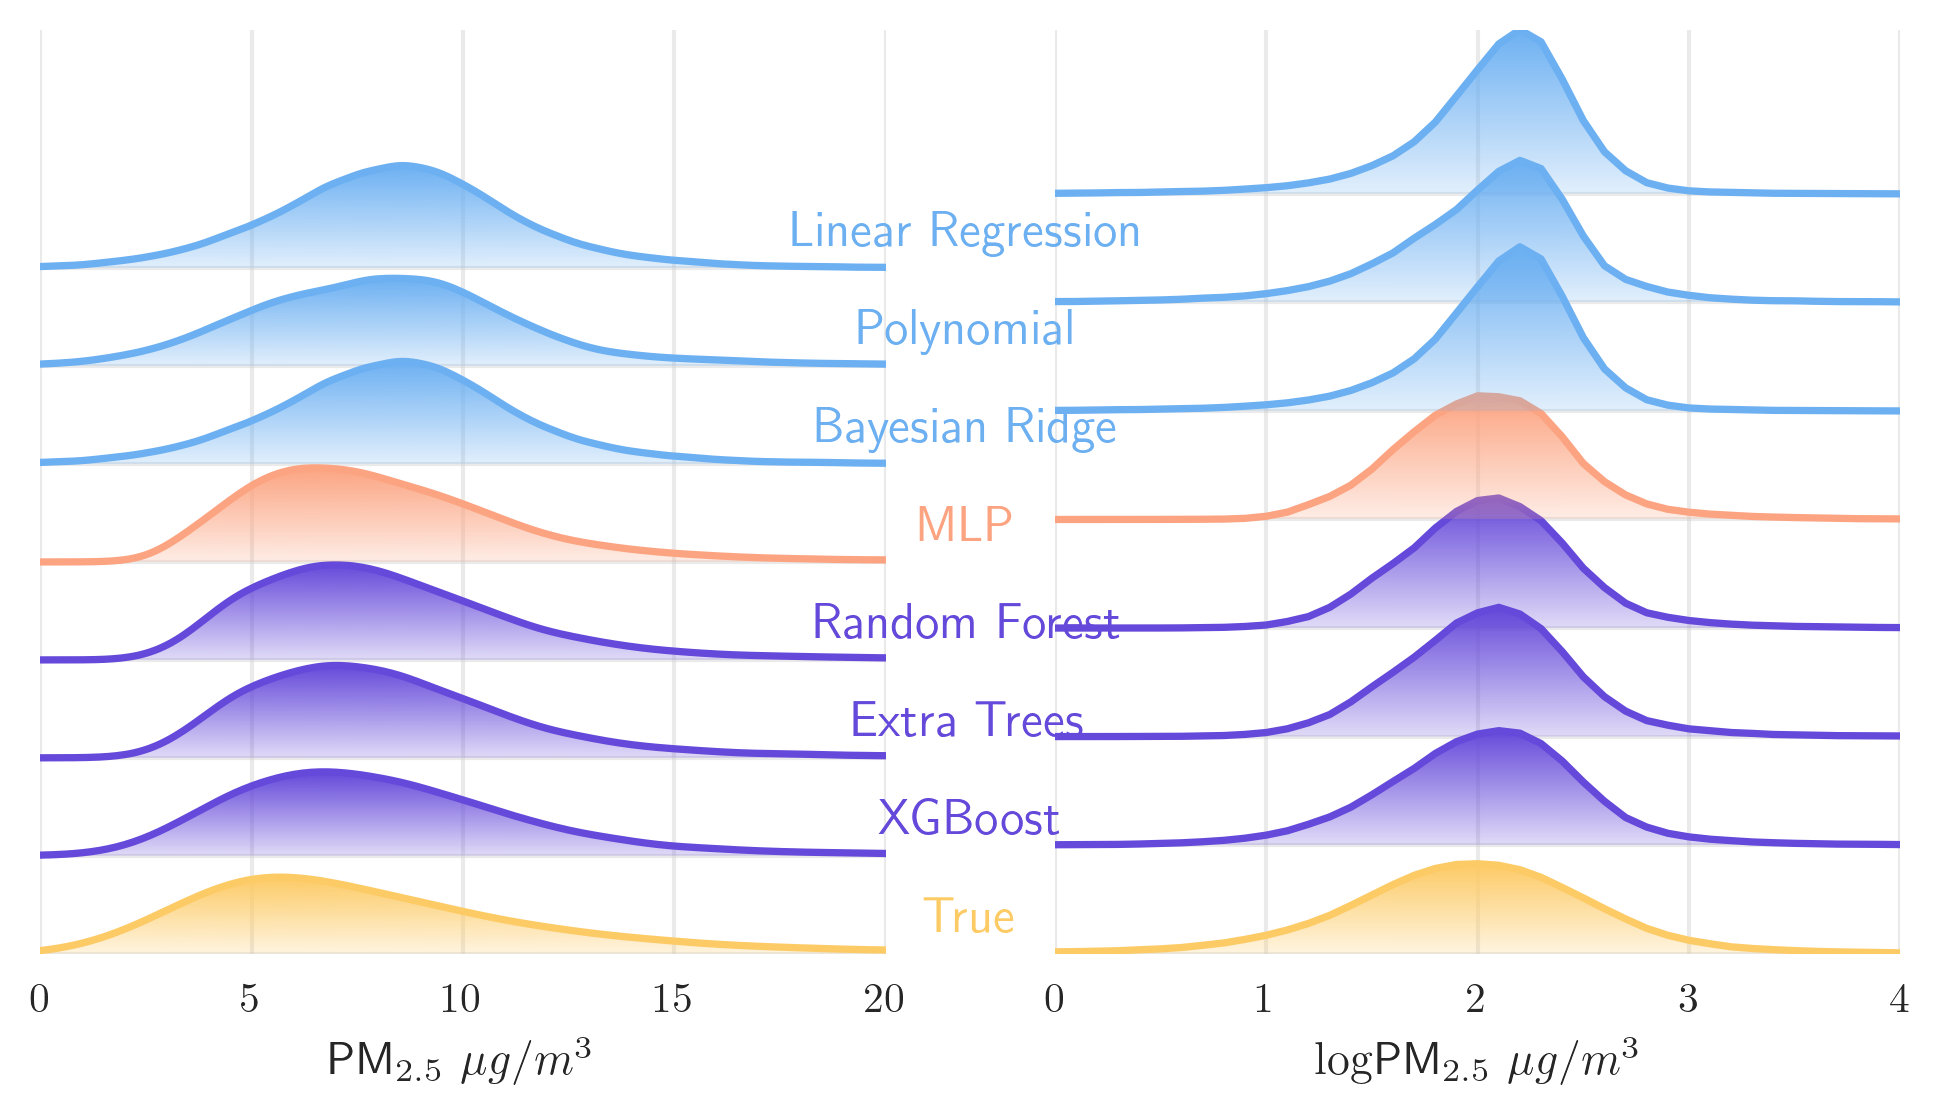

In [40]:
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.patches as patches

def plot_densities(ax, predictions, colors, x, ys, lw = 3, alpha_min=0.2, alpha_max = 1.0):
    for idx, (column, color) in enumerate(zip(predictions.columns, colors)):
        gkde = gaussian_kde(predictions[column])
        y = ys[idx] + gkde.evaluate(x)
        line, = ax.plot(x, y, color=color)
        
        h, w = 100, 1
        z = np.empty((h, w, 4), dtype=float)
        rgb = mcolors.colorConverter.to_rgb(color)
        z[:,:,:3] = rgb
        z[:,:,-1] = np.linspace(alpha_min, alpha_max, h)[:,None]

        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        extent = [xmin, xmax, ymin, ymax]
        im = ax.imshow(z, aspect='auto', extent=extent,
                       origin='lower', zorder=line.get_zorder())

        xy = np.column_stack([x, y])
        xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
        clip_path = patches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
        ax.add_patch(clip_path)
        im.set_clip_path(clip_path)

        
x = np.arange(0, 100, 0.1)
ys = np.linspace(0, 1, len(predictions.columns))
logged = predictions[predictions > 0].apply(np.log)
no_infs = logged[~logged.isin([np.nan, np.inf, -np.inf]).any(1)]

loggedmax = no_infs.max().max()
loggedys = np.linspace(0, loggedmax, len(predictions.columns))

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(8,4))
(ax1, ax2) = axes

plot_densities(ax1, predictions[predictions.columns[::-1]], colors[::-1], x, ys)
plot_densities(ax2, no_infs[no_infs.columns[::-1]], colors[::-1], x, loggedys)

ax1.grid(True, alpha=0.4)
ax1.set_yticks(ys)
ax1.set_yticklabels('')
ax1.spines[:].set_visible(False)
ax1.set_xlabel('PM$_{2.5}~\mu g/m^3$')
ax1.set_xlim((0, 20))
ax1.set_ylim((0, 1.348))

for line, label, y in zip(ax1.get_lines(), predictions.columns[::-1], ys):
    ax1.annotate(label, xy=(1,y), xytext=(20,8), color=line.get_color(), 
                xycoords = ax1.get_yaxis_transform(), textcoords="offset points",
                size=12, va="center", ha='center')
    
ax2.zorder=-10
    
ax2.grid(True, alpha=0.4)
ax2.set_yticks(loggedys)
ax2.set_yticklabels('')
ax2.spines[:].set_visible(False)
ax2.set_xlabel('$\log$PM$_{2.5}~\mu g/m^3$')
ax2.set_xlim((0, 4))
ax2.set_ylim((0, np.max([line.get_ydata().max() for line in ax2.get_lines()])))

fig.savefig(f'{save_path}/side-by-side-densities-all_years.png', format='png', bbox_inches = "tight")

In [41]:
# https://stackoverflow.com/a/29347731/5217293

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFilter

def gradient_fill(x, y, fill_color=None, ax=None, zfunc=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if zfunc is None:
        h, w = 100, 1
        z = np.empty((h, w, 4), dtype=float)
        rgb = mcolors.colorConverter.to_rgb(fill_color)
        z[:,:,:3] = rgb
        z[:,:,-1] = np.linspace(0, alpha, h)[:,None]
    else:
        z = zfunc(x, y, fill_color=fill_color, alpha=alpha)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = patches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    ax.autoscale(True)
    return line, im

def zfunc(x, y, fill_color='k', alpha=1.0):
    scale = 10
    x = (x*scale).astype(int)
    y = (y*scale).astype(int)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()

    w, h = xmax-xmin, ymax-ymin
    z = np.empty((h, w, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    # Build a z-alpha array which is 1 near the line and 0 at the bottom.
    img = Image.new('L', (w, h), 0)  
    draw = ImageDraw.Draw(img)
    xy = np.column_stack([x, y])
    xy -= xmin, ymin
    # Draw a blurred line using PIL
    draw.line(list(map(tuple, xy)), fill=255, width=15)
    img = img.filter(ImageFilter.GaussianBlur(radius=100))
    # Convert the PIL image to an array
    zalpha = np.asarray(img).astype(float) 
    zalpha *= alpha/zalpha.max()
    # make the alphas melt to zero at the bottom
    n = zalpha.shape[0] // 4
    zalpha[:n] *= np.linspace(0, 1, n)[:, None]
    z[:,:,-1] = zalpha
    return z

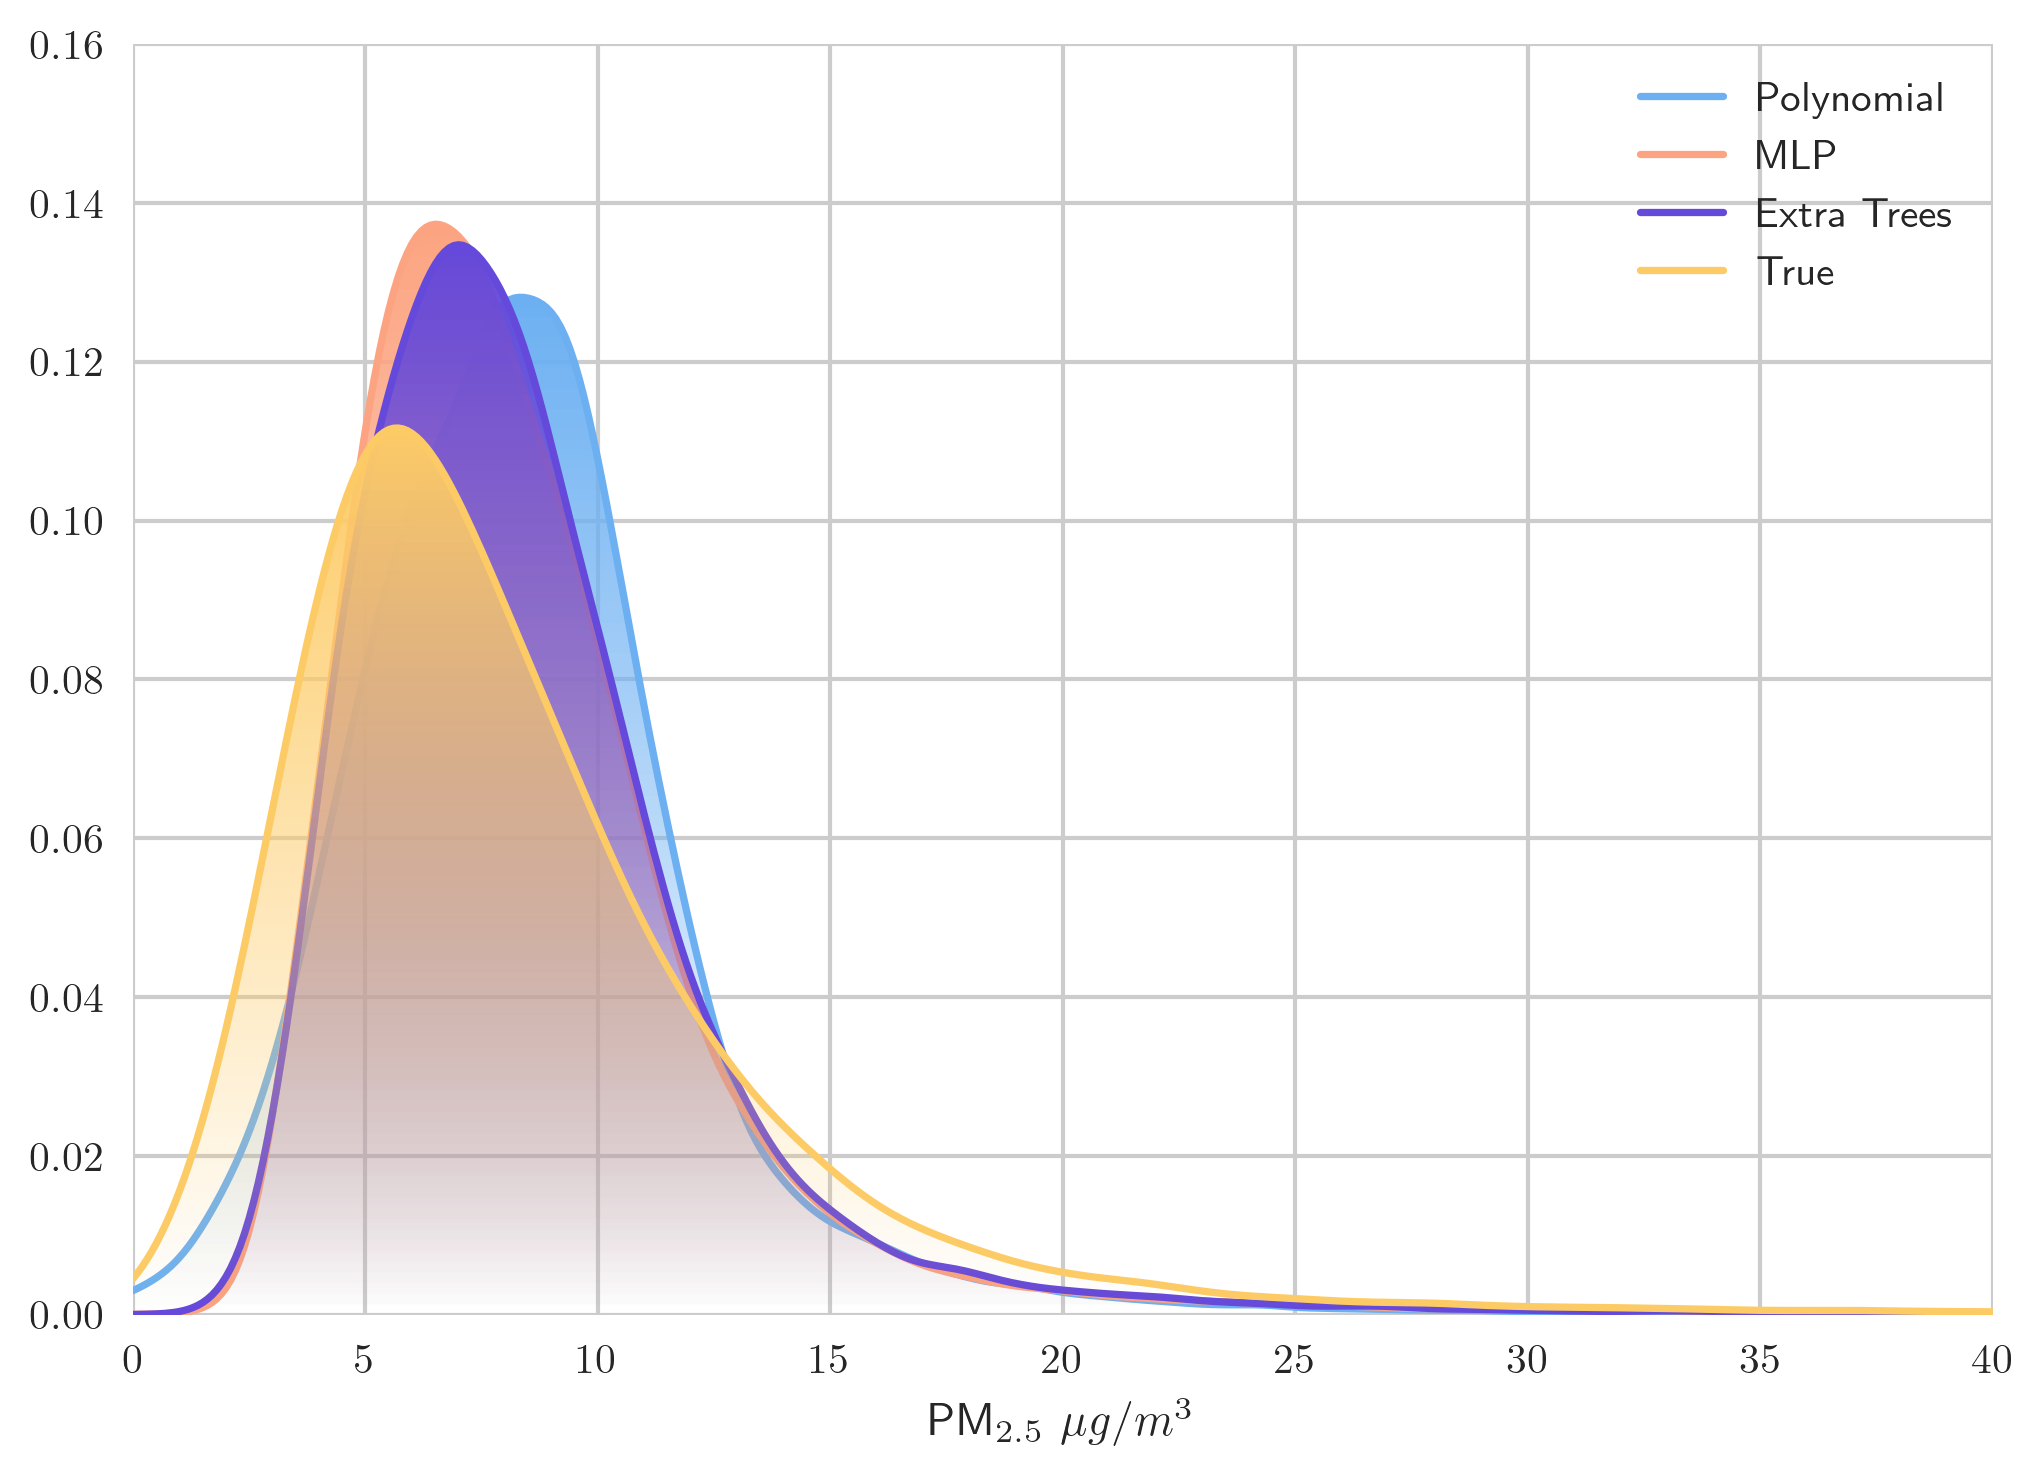

In [42]:
from scipy.stats import gaussian_kde

x_range = np.arange(0, 100, 0.1)

densities = {}

fig, ax = plt.subplots(dpi=300)
lines = []

alpha=0.4

for idx, (column, color) in enumerate(zip(['Polynomial', 'MLP', 'Extra Trees'], [linear_color, nn_color, tree_color])):
    gkde = gaussian_kde(predictions[column])
    densities[column] = gkde
    density = gkde.evaluate(x_range)
    lines.append(gradient_fill(x_range, density, ax=ax, fill_color=color, color=color)[0])#, alpha=alpha - idx*alpha*.1)[0])

gkde = gaussian_kde(predictions['True'])
densities['True'] = gkde
density = gkde.evaluate(x_range)
lines.append(gradient_fill(x_range, density, ax=ax, fill_color='#FDCB66', color='#FDCB66')[0])

ax.legend(lines, ['Polynomial', 'MLP', 'Extra Trees', 'True'], loc='upper right')
ax.set_xlabel('PM$_{2.5}~\mu g/m^3$')

ax.set_ylim((0, 0.16))
ax.set_xlim((0, 40))
ax.spines[:].set_visible(False)

fig.savefig(f'{save_path}/densities-best-performers-shaded-all_years.png', format='png', bbox_inches = "tight")

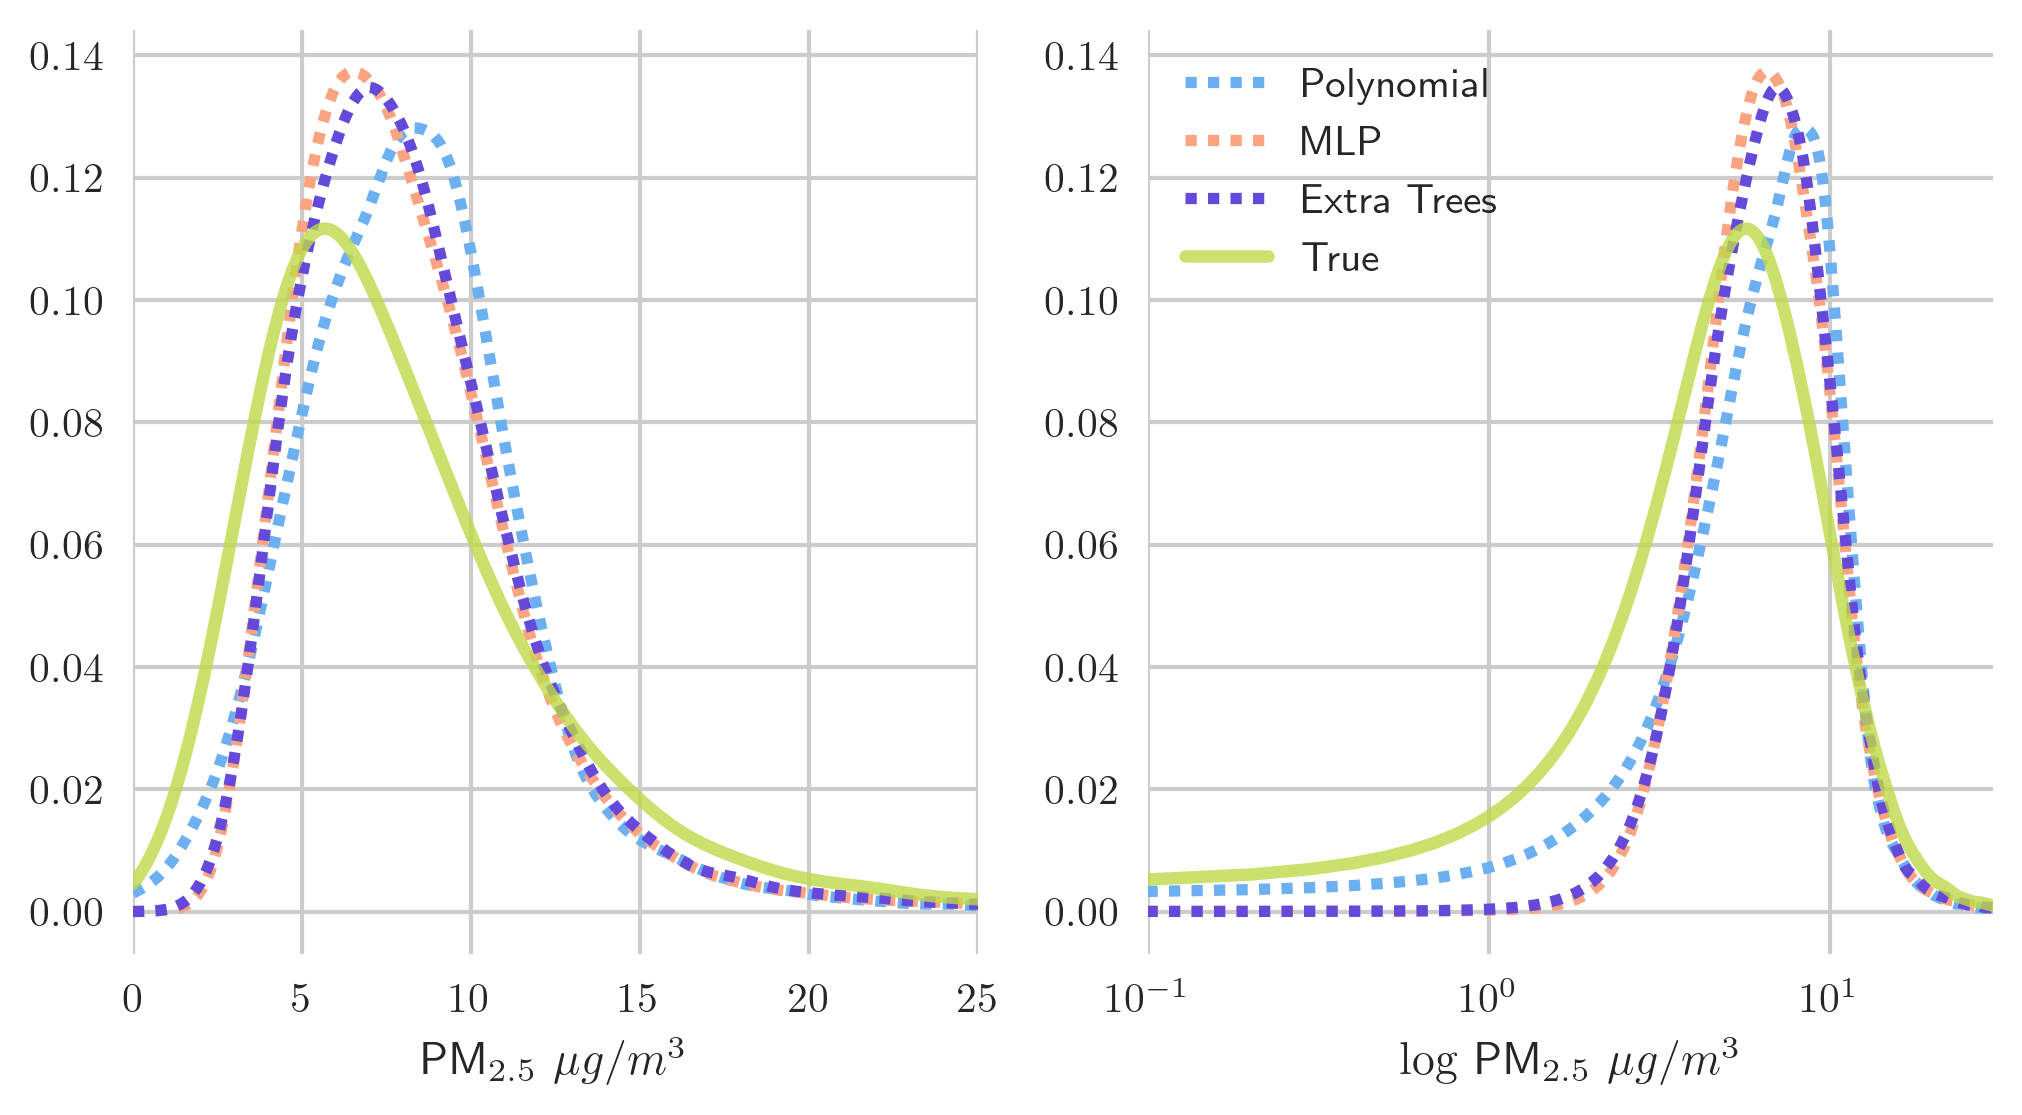

In [43]:
from scipy.stats import gaussian_kde

x_range = np.arange(0, 100, 0.1)

densities = {}

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(8,4))
(ax1, ax2) = axes

for ax in axes:
    lines = []

    lw = 3
    alpha=0.8

    for idx, (column, color) in enumerate(zip(['Polynomial', 'MLP', 'Extra Trees'], [linear_color, nn_color, tree_color])):
        gkde = gaussian_kde(predictions[column])
        densities[column] = gkde
        density = gkde.evaluate(x_range)
        lines.append(ax.plot(x_range, density, ls='--', color=color, lw=lw*.9, dashes=(1, 1))[0])

    gkde = gaussian_kde(predictions['True'])
    densities['True'] = gkde
    density = gkde.evaluate(x_range)
    lines.append(ax.plot(x_range, density, color='#BFDA49', lw=lw, alpha=alpha)[0])

    ax.spines[:].set_visible(False)
    

ax1.set_xlabel('PM$_{2.5}~\mu g/m^3$')
ax1.set_xlim((0, 25))

ax2.set_xscale('log')
ax2.set_xlim((.1, 30))
ax2.legend(lines, ['Polynomial', 'MLP', 'Extra Trees', 'True'], loc='best')
ax2.set_xlabel('$\log$ PM$_{2.5}~\mu g/m^3$')

fig.savefig(f'{save_path}/densities-best-performers-all_years.png', format='png', bbox_inches = "tight")

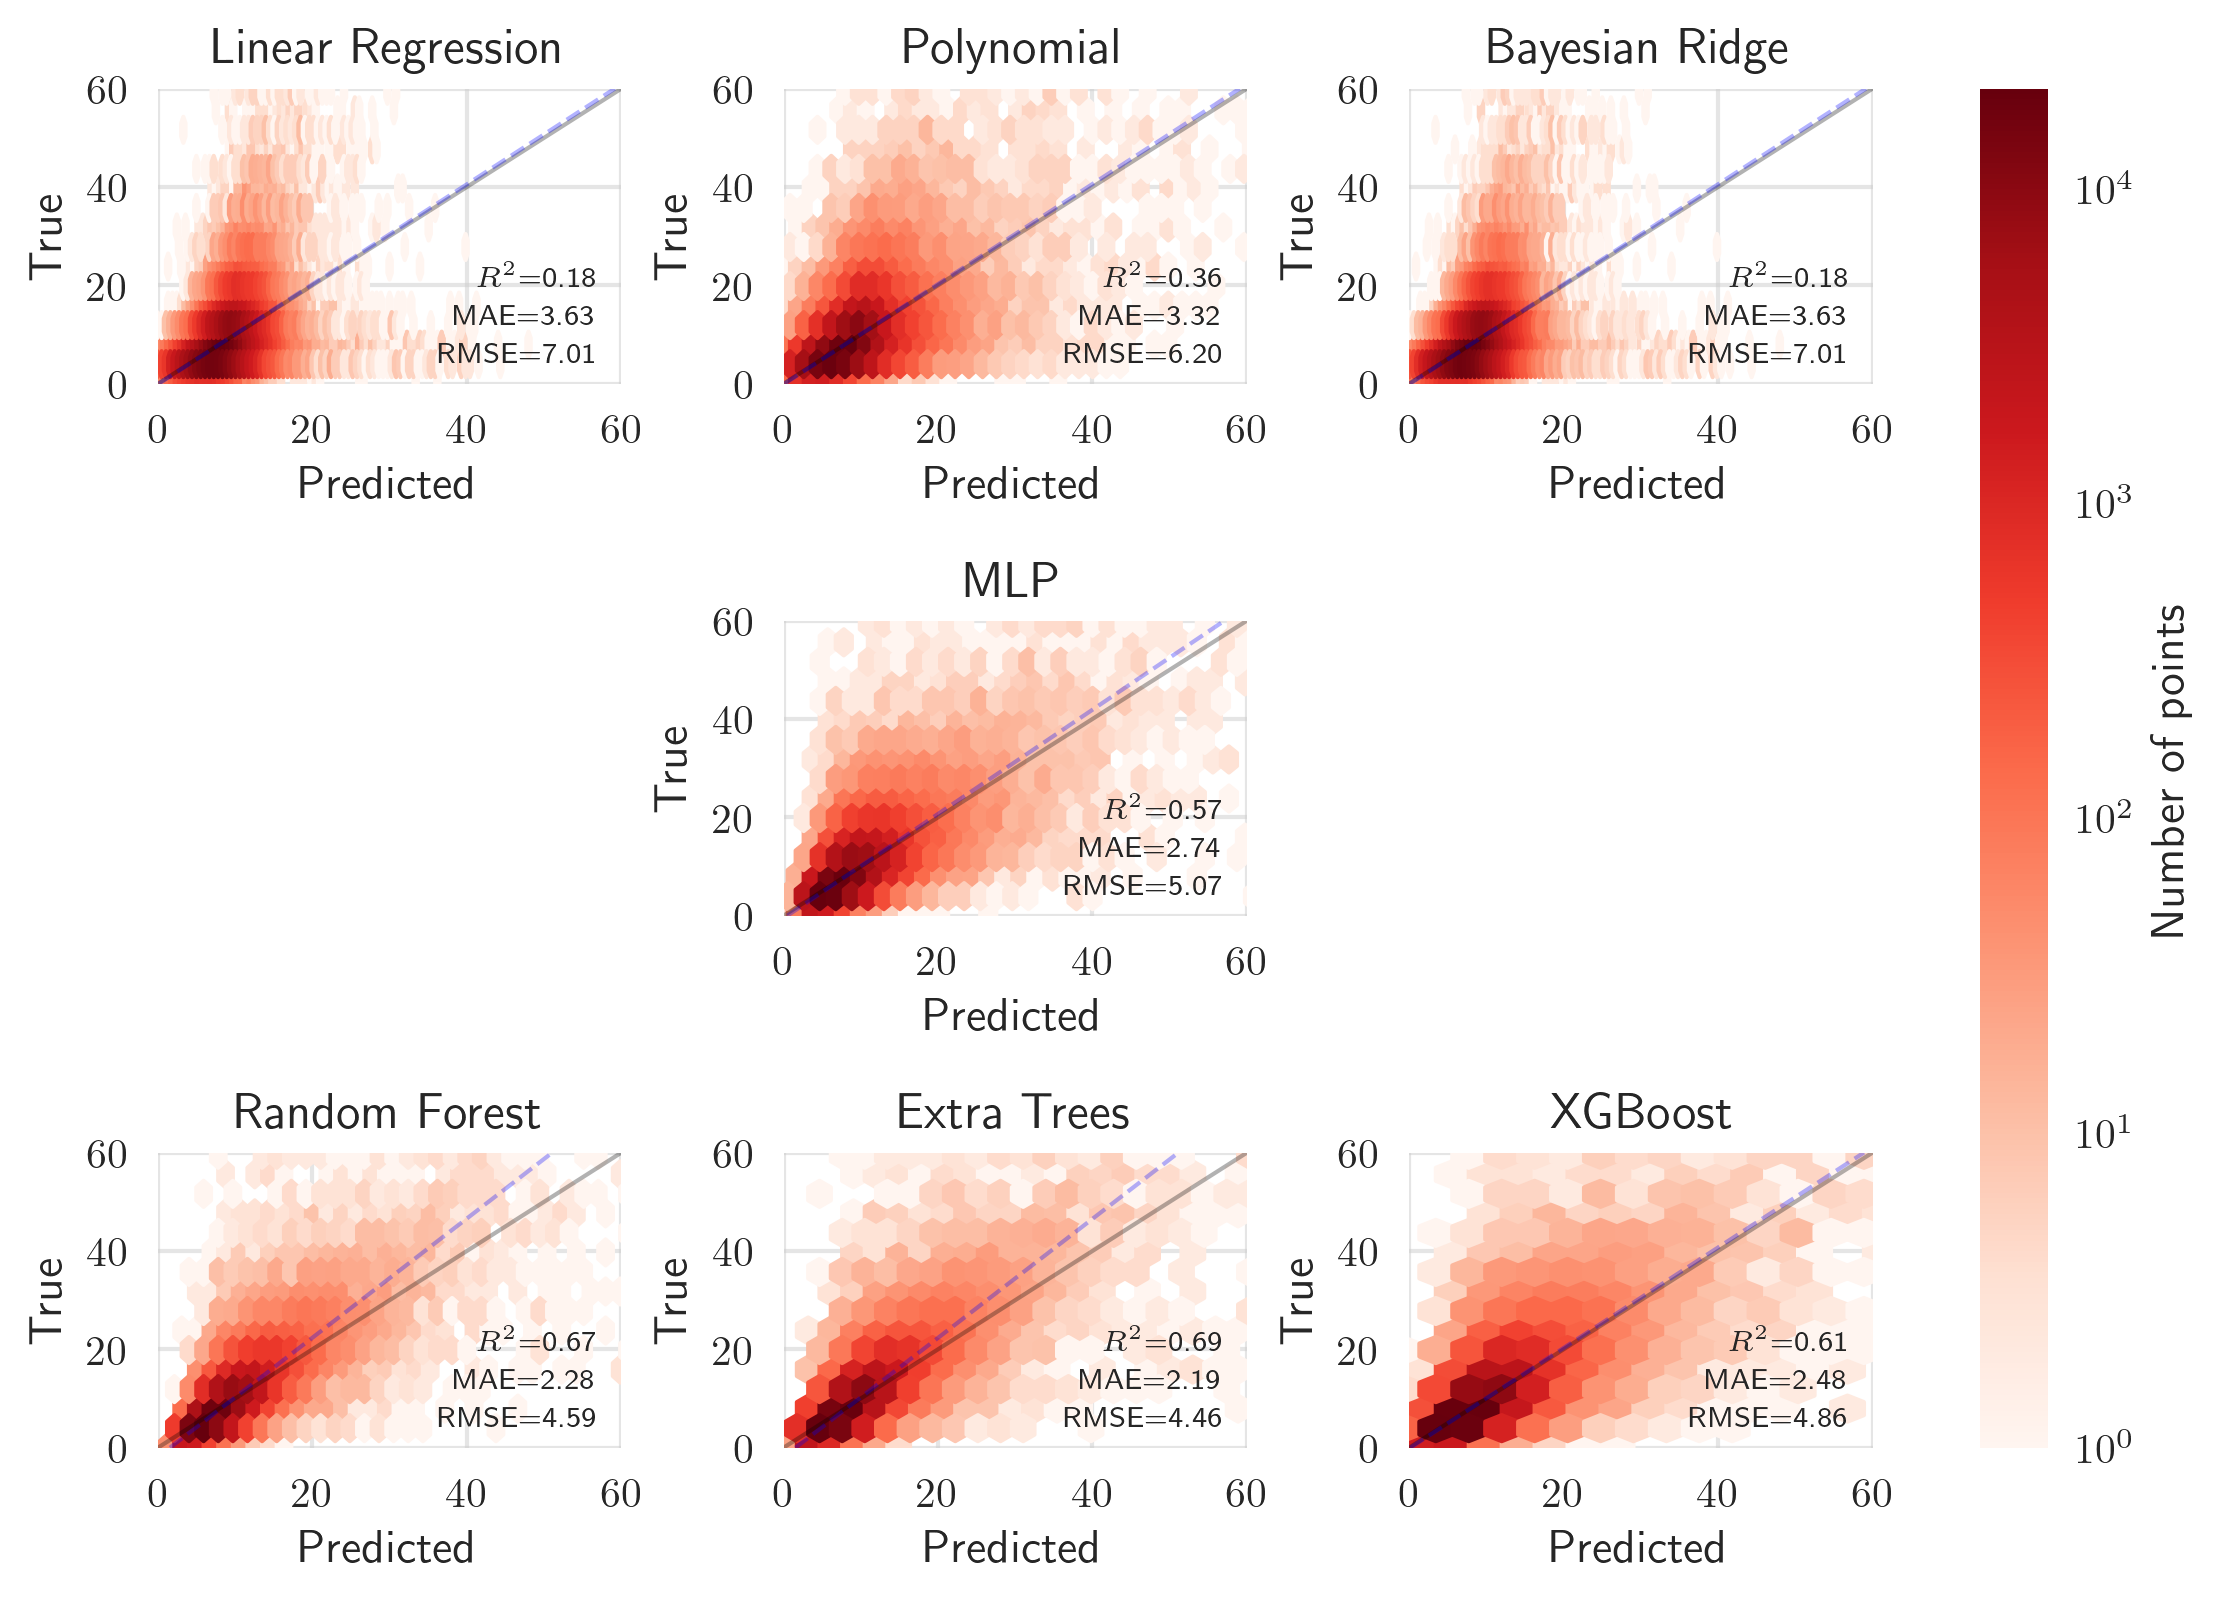

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

fig, axes = plt.subplots(3, 3, dpi=300)

axs = iter(axes.ravel())

for c in predictions.columns:
    if c == 'True':
        continue
    
    ax = next(axs)
    
    if c == 'MLP':
        ax.set_visible(False)
        ax = next(axs)

    mappable = ax.hexbin(predictions[c], predictions['True'], bins='log', cmap='Reds')

    ax.set_title(c)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    x = predictions[c].values.reshape(-1, 1)
    y = predictions['True']

    lin = LinearRegression().fit(x, y)
    
    ax.axline(xy1=(0, 0), slope=1, 
              linestyle="-", 
              lw=1,
              color="black", 
              alpha=0.3)
    
    ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), 
              linestyle="--", 
              lw=1,
              color="blue", 
              alpha=0.3)
    
    r2 = lin.score(x, y)
    mae = mean_absolute_error(y_true=y, y_pred=x)
    rmse = mean_squared_error(y_true=y, y_pred=x, squared=False)
    
    top = .4
    left = 0.95
    args = dict(fontsize='xx-small', va='top', ha='right', transform=ax.transAxes)
    sep = 0.13
    ax.text(left, top, 
            f'$R^2$={r2:.2f}', 
            **args)
    ax.text(left, top-sep,
            f'MAE={mae:.2f}', 
            **args)
    ax.text(left, top-2*sep, 
            f'RMSE={rmse:.2f}', 
            **args)

    ax.spines[:].set_visible(False)
    
#     ax.set_xscale('symlog')
#     ax.set_yscale('symlog')

#     ax.set_xlim((0, np.percentile(predictions['True'], 99)))
#     ax.set_ylim((0, np.percentile(predictions[c], 99)))
#     ax.set_xlim((0, 110))
#     ax.set_ylim((0, 110))
    ax.set_xlim((0, 60))
    ax.set_ylim((0, 60))
    ax.grid(True, alpha=0.5)
    
    if c == 'MLP':
        ax = next(axs)
        ax.set_visible(False)

fig.tight_layout()
cbar = fig.colorbar(mappable, ax=axes.ravel().tolist())
cbar.set_label('Number of points')
cbar.outline.set_linewidth(0)

for ax in axs:
    ax.set_visible(False)
    
fig.savefig(f'{save_path}/prediction_scatter_plots-with-scores-all_years.png', format='png', bbox_inches = "tight")

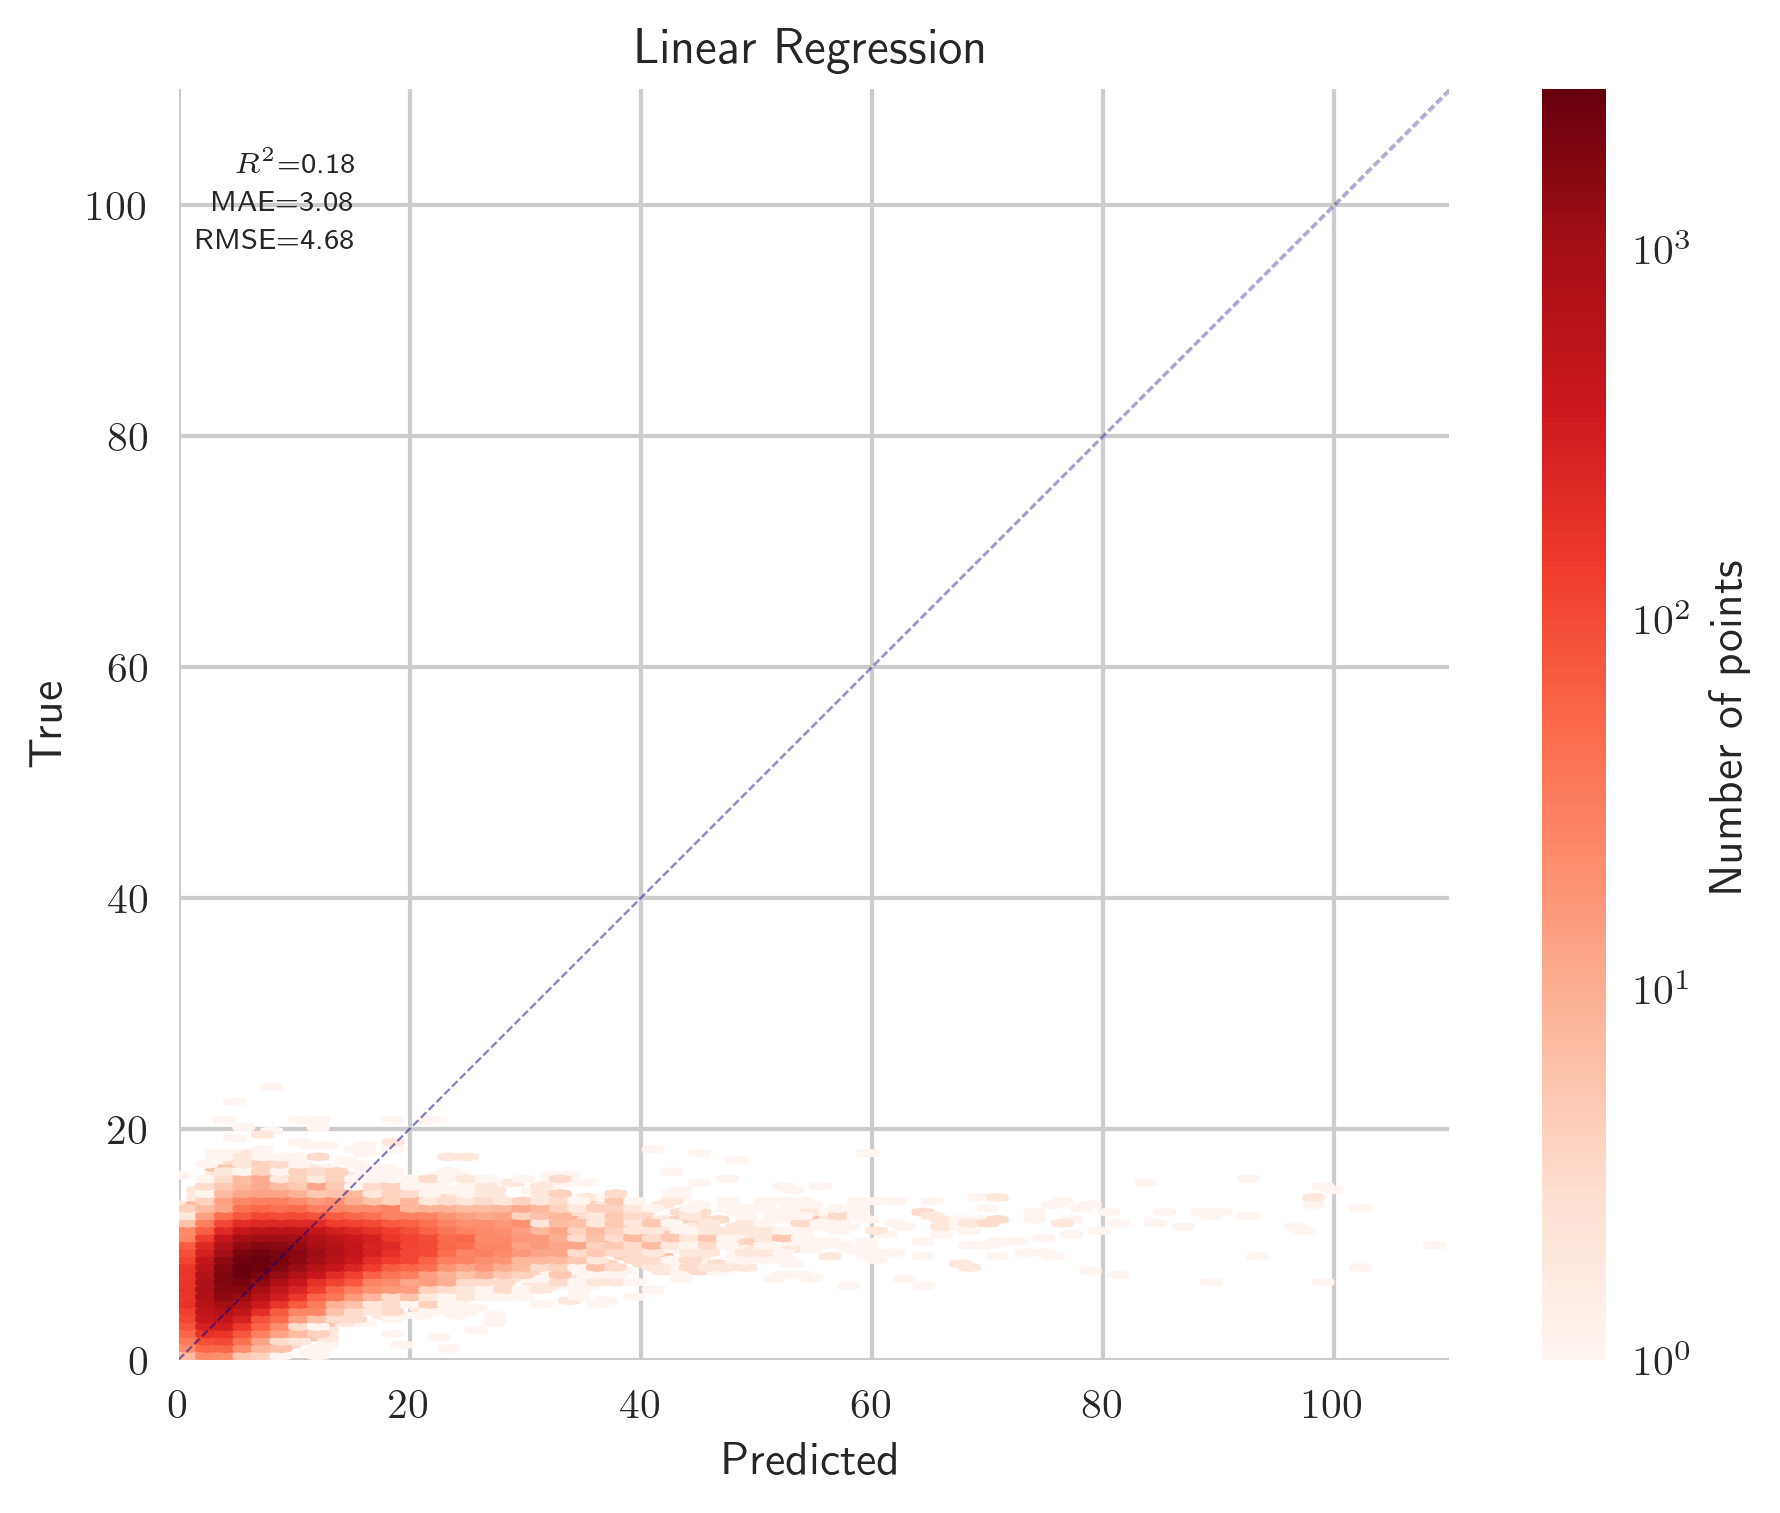

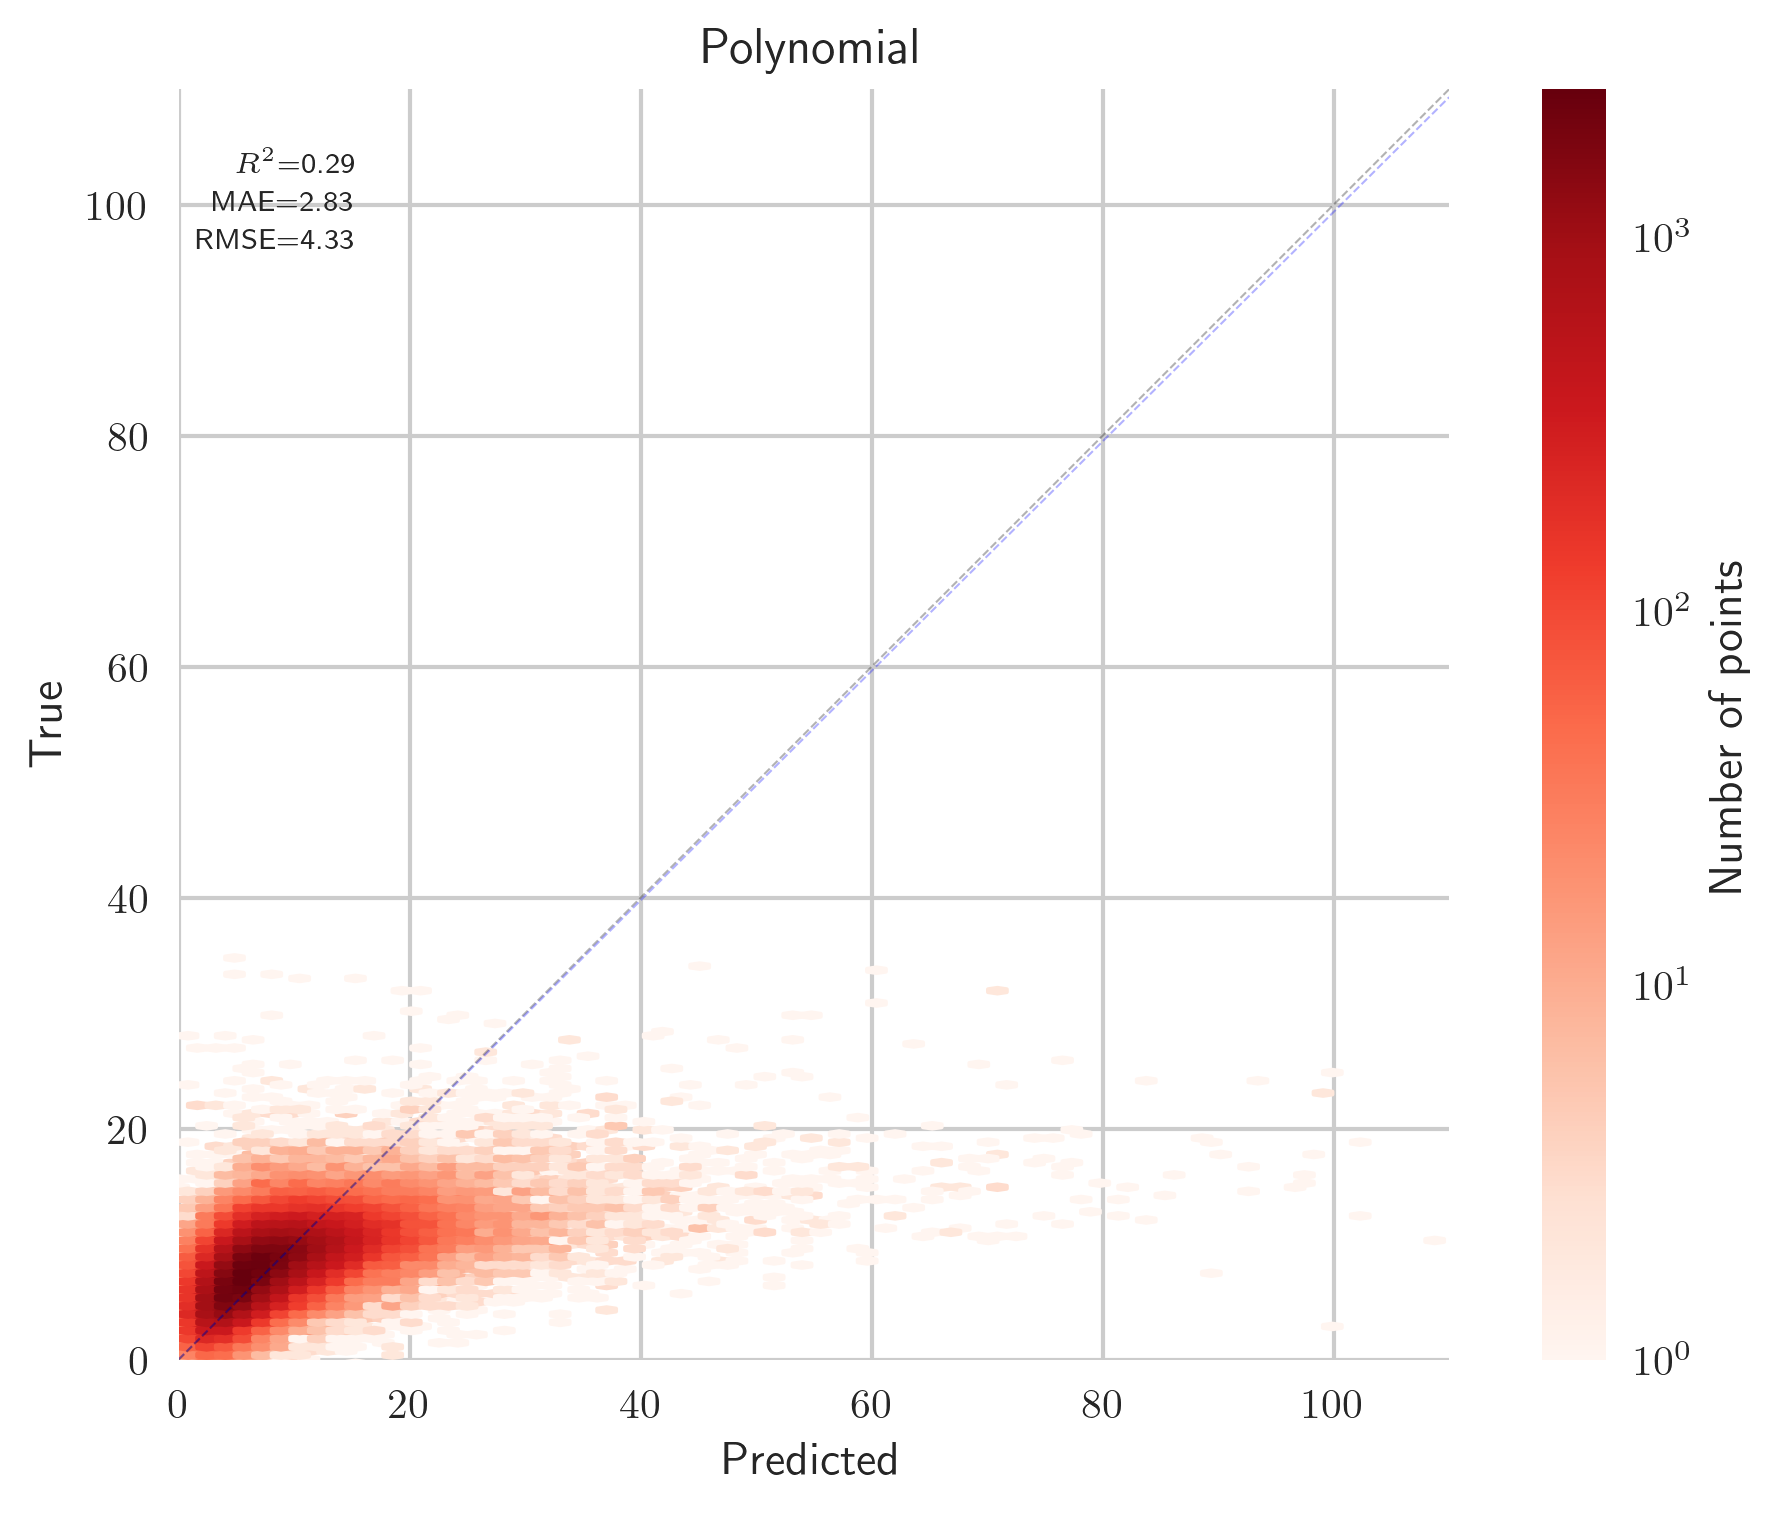

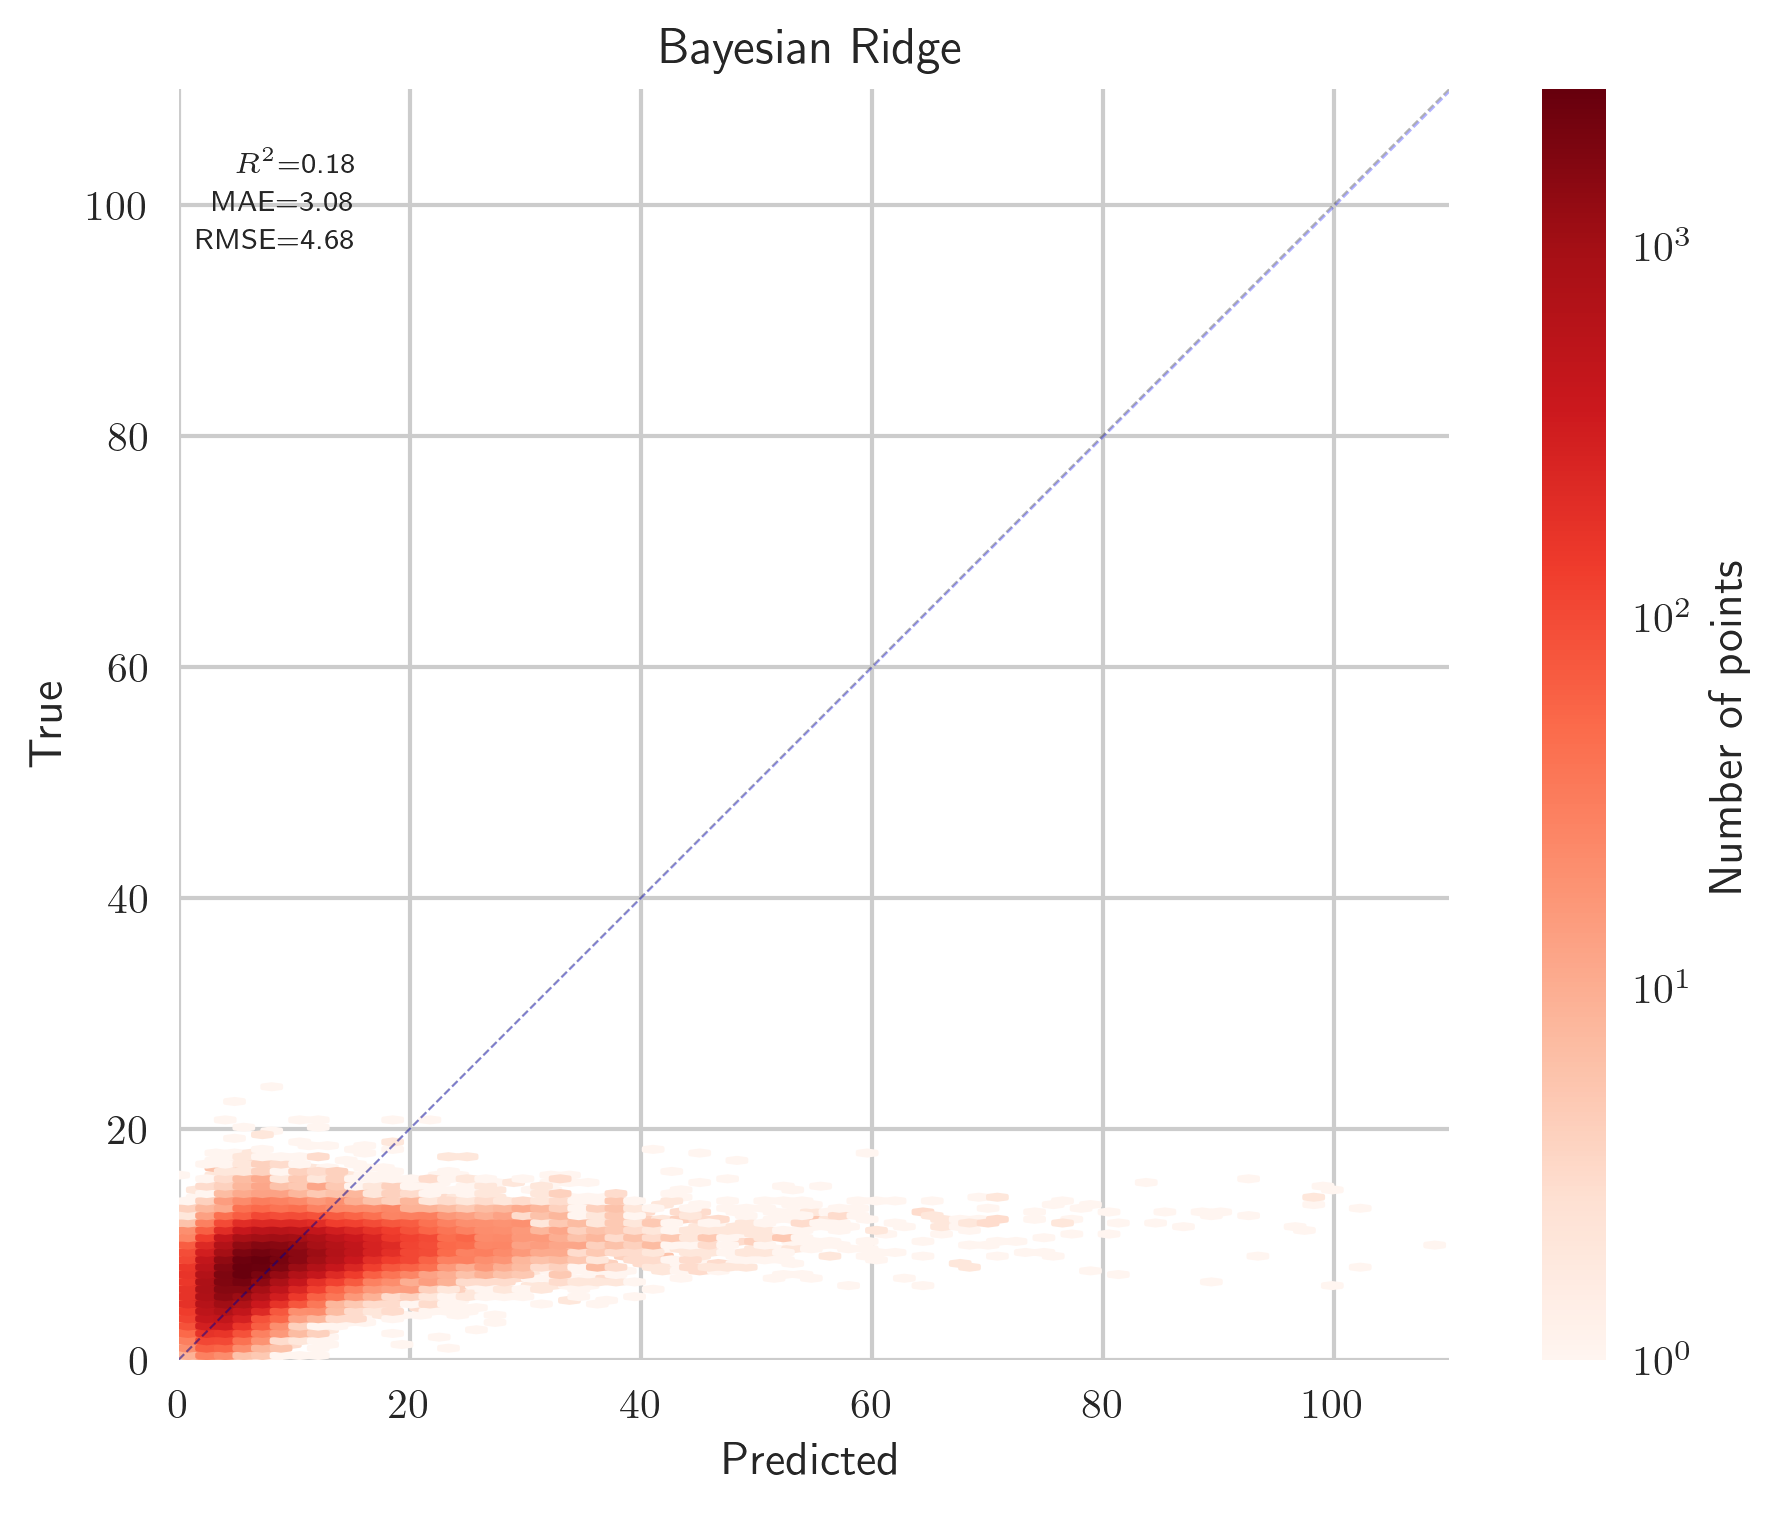

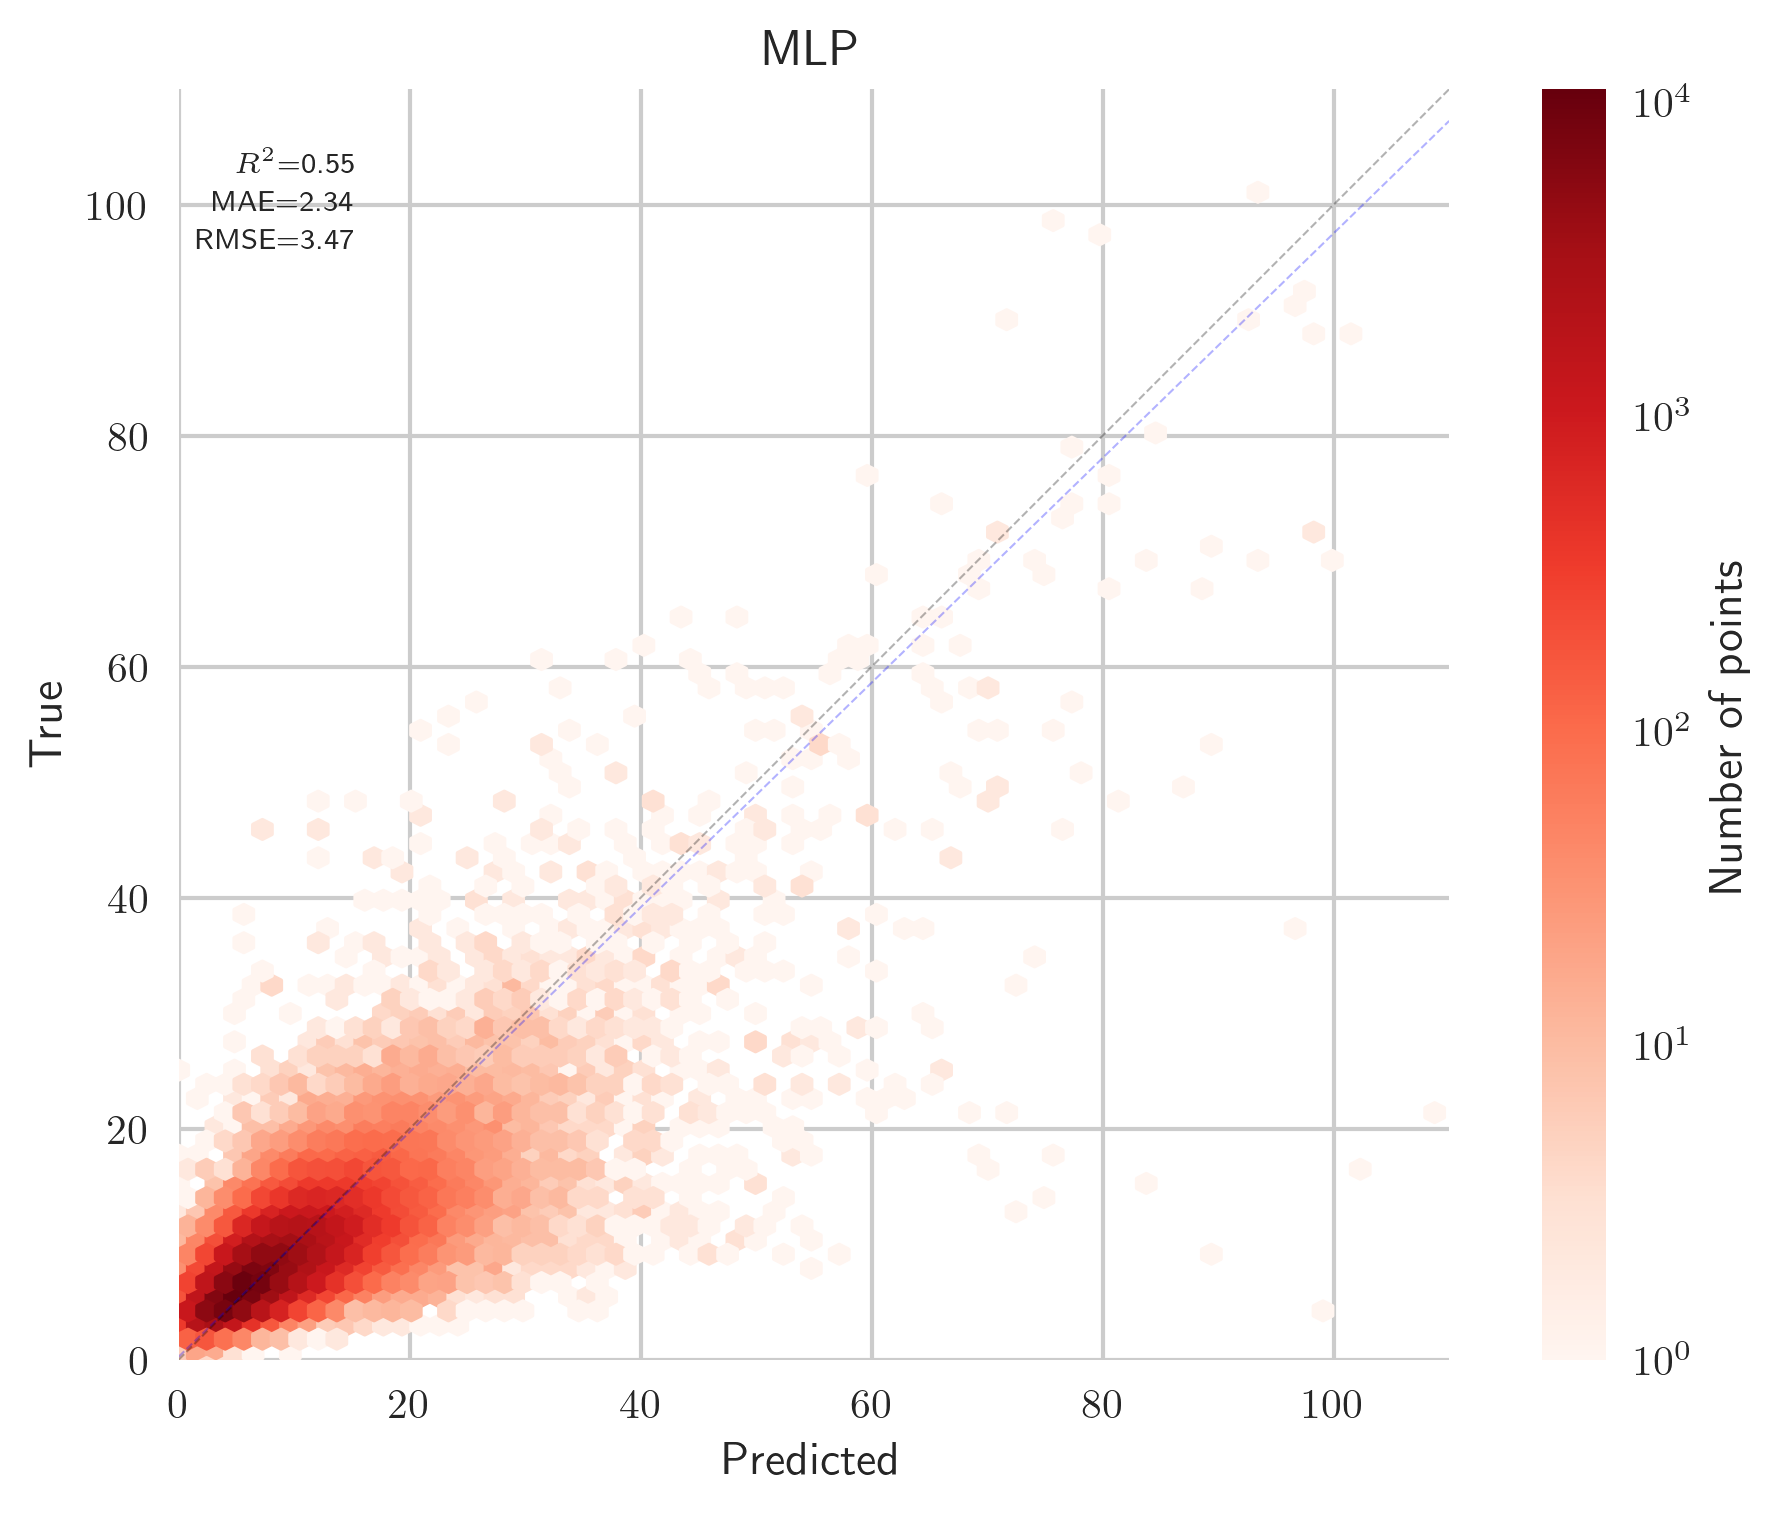

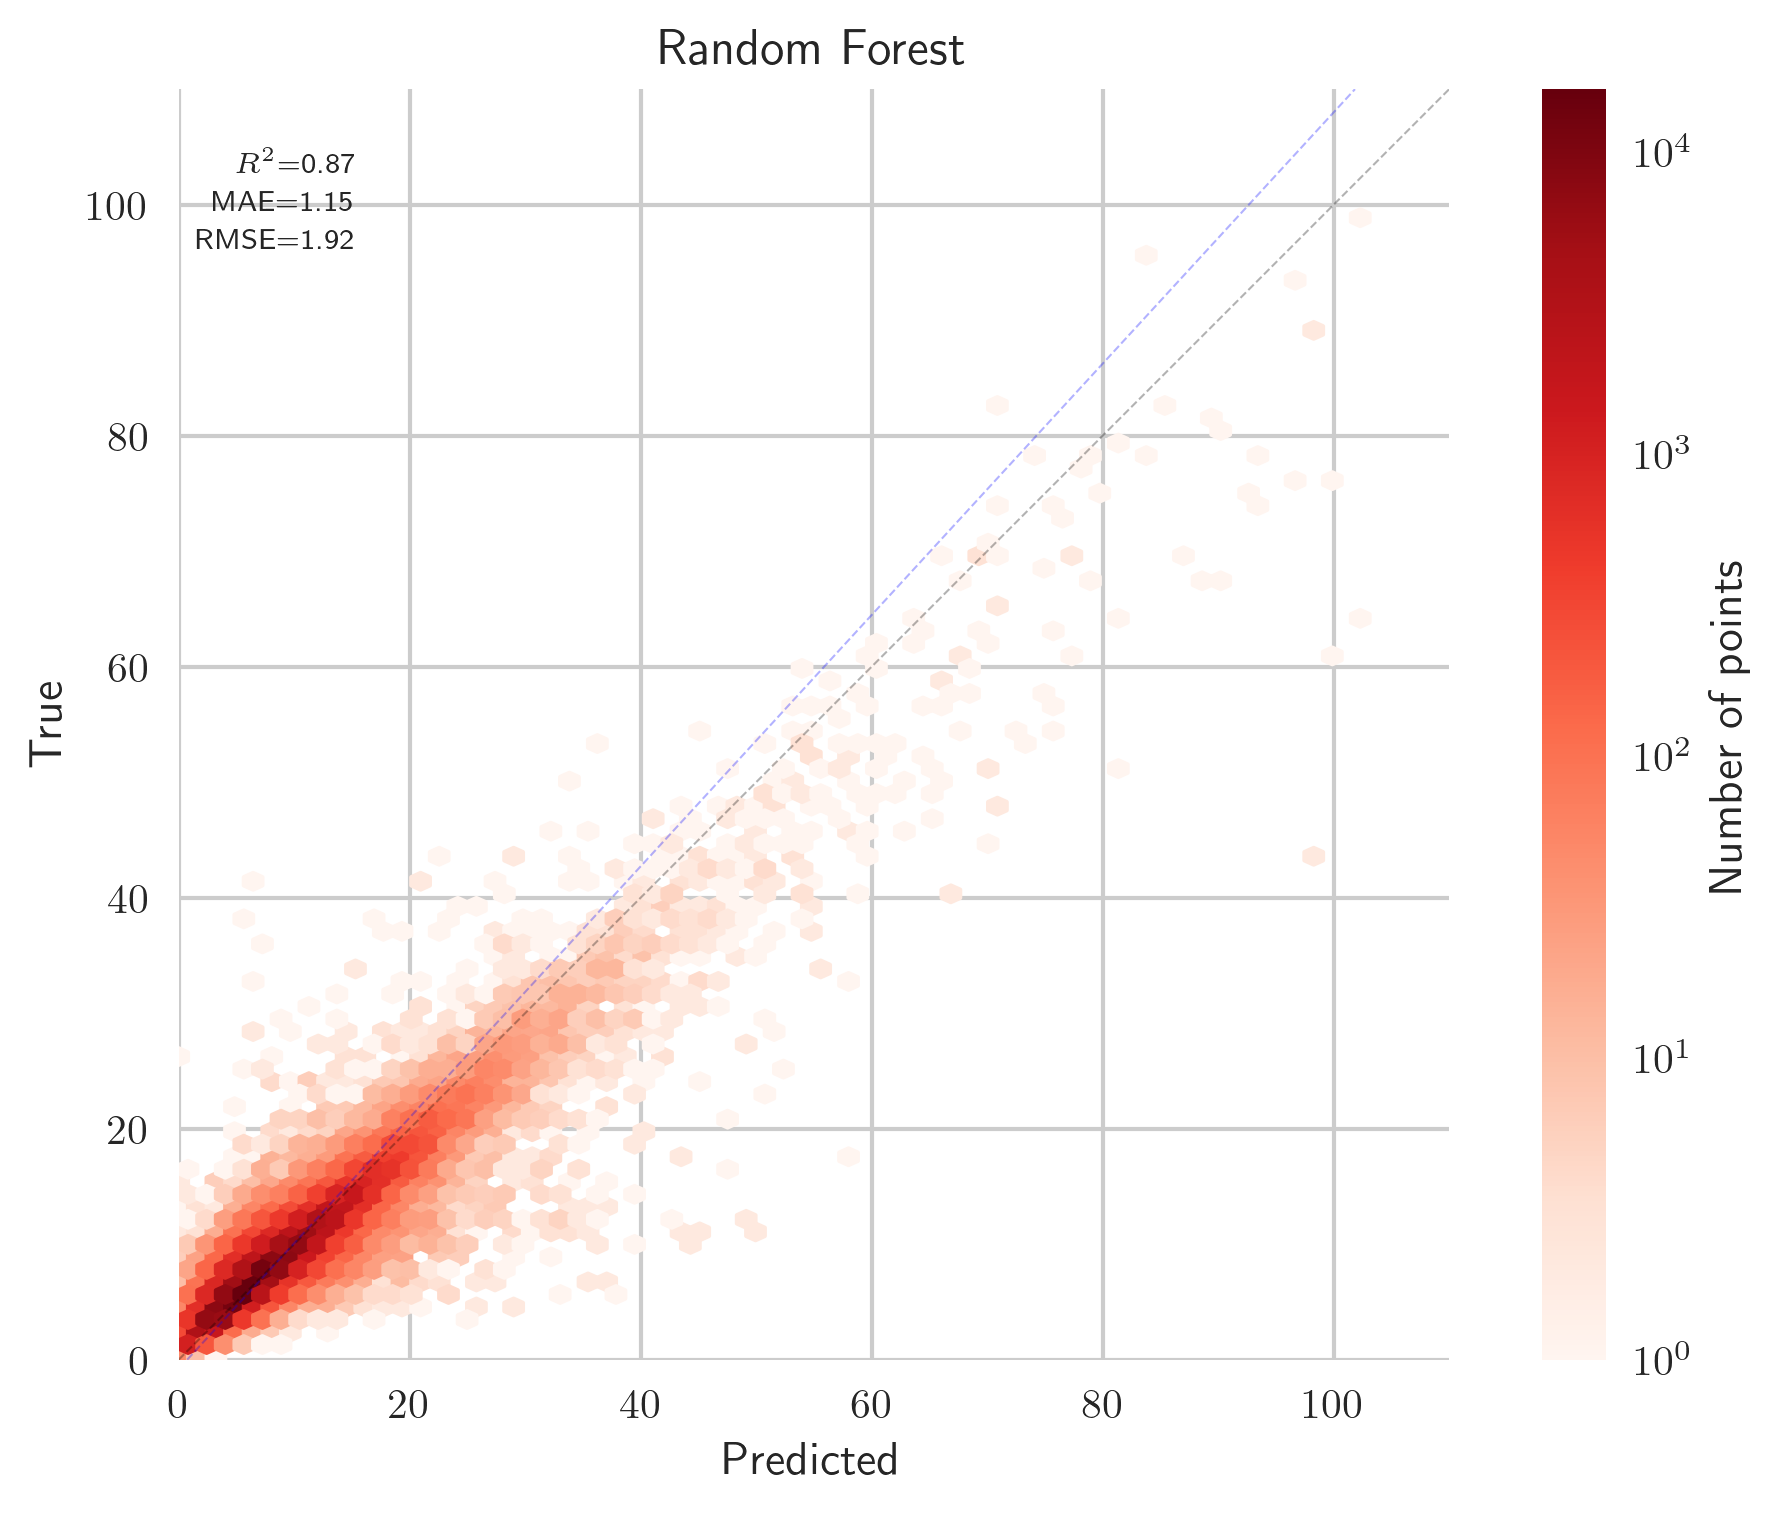

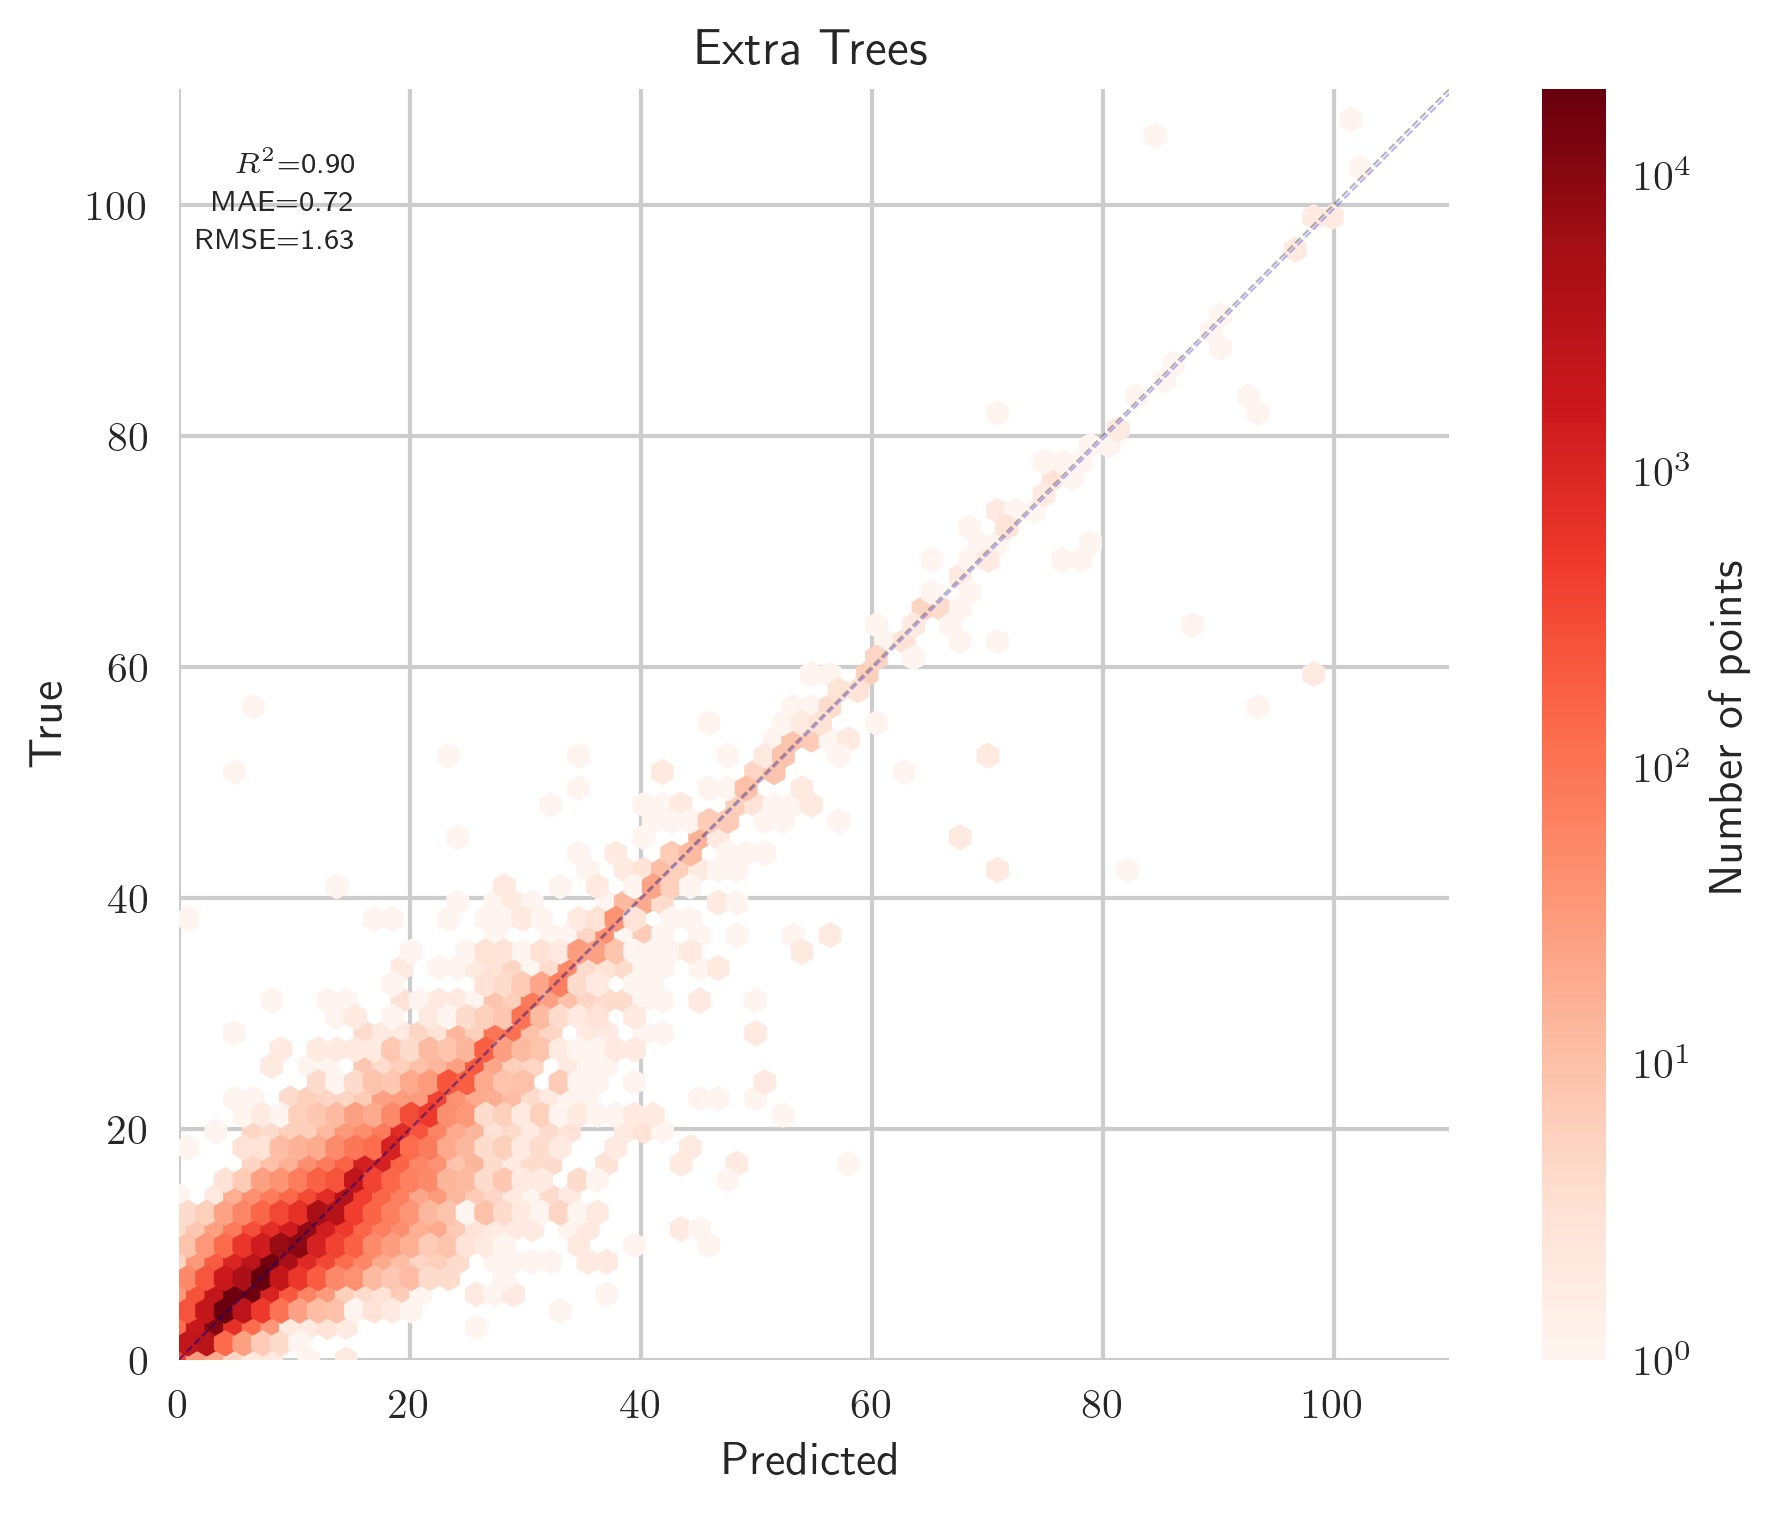

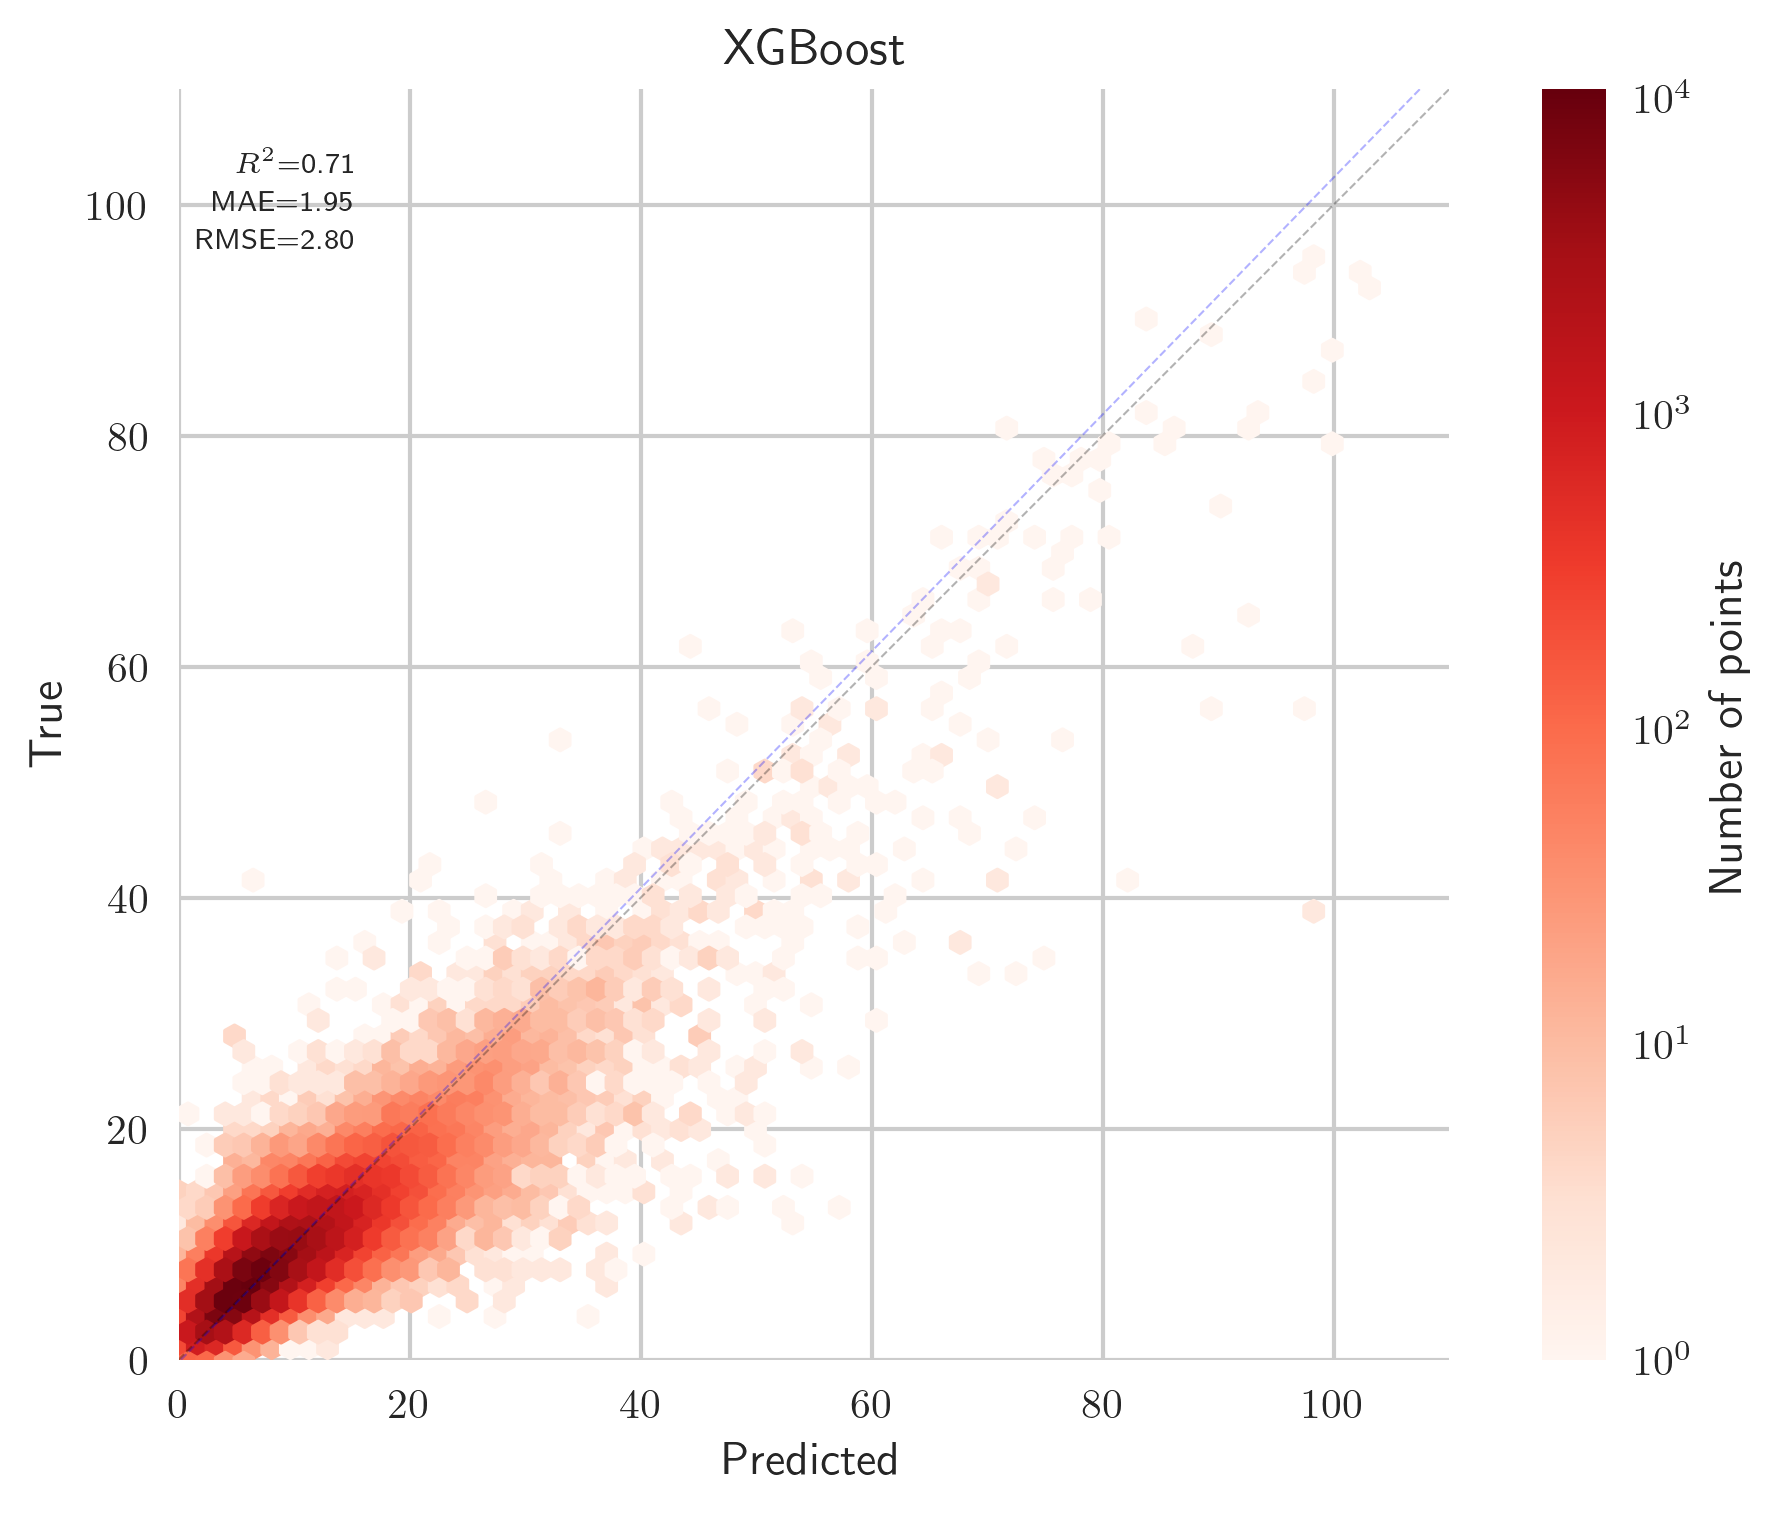

In [68]:
from sklearn.linear_model import LinearRegression


for c in predictions.columns:
    if c == 'True':
        continue
        
    fig, ax = plt.subplots(dpi=300)

    mappable = ax.hexbin(predictions['True'], predictions[c], bins='log', cmap='Reds')

    ax.set_title(c)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    x = predictions[c].values.reshape(-1, 1)
    y = predictions['True']

    lin = LinearRegression().fit(x, y)
    
    ax.axline(xy1=(0, 0), slope=1, 
              linestyle="--", 
              lw=0.5,
              color="black", 
              alpha=0.3)
    
    ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), 
              linestyle="--", 
              lw=0.5,
              color="blue", 
              alpha=0.3)
    
    r2 = lin.score(x, y)
    mae = mean_absolute_error(y_true=y, y_pred=x)
    rmse = mean_squared_error(y_true=y, y_pred=x, squared=False)
    
    top = .95
    left = 0.14
    args = dict(fontsize='xx-small', va='top', ha='right', transform=ax.transAxes)
    sep = 0.03
    ax.text(left, top, 
            f'$R^2$={r2:.2f}', 
            **args)
    ax.text(left, top-sep,
            f'MAE={mae:.2f}', 
            **args)
    ax.text(left, top-2*sep, 
            f'RMSE={rmse:.2f}', 
            **args)
    
    ax.set_aspect('equal')

    ax.spines[:].set_visible(False)

    ax.set_xlim((0, 110))
    ax.set_ylim((0, 110))
    
    cbar = fig.colorbar(mappable, ax=ax)
    cbar.set_label('Number of points')
    cbar.outline.set_linewidth(0)
    fig.savefig(f'{save_path}/prediction_scatter_plots_{c.replace(" ", "_")}.png', format='png', bbox_inches = "tight")

## Average Fit Times

In [45]:
models = list(mc.cross_val_scores_.keys())
fits, error = [], []
for model in models:
    res = mc.cross_val_scores_[model]
    fits.append(res['fit_time'].mean())
    error.append(np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])))
    
fit_df = pd.DataFrame({'Fit Time': fits, 'Error': error}, index=models)#.reindex(order)
fit_df.to_csv(f'{save_path}/fit_times-all_years.csv')
fit_df

,Fit Time,Error
Linear Regression,2.262114,0.260810
Polynomial,72.935957,7.193848
Bayesian Ridge,3.565620,0.366895
MLP,365.270617,35.486741
Random Forest,539.217652,2.763920
Extra Trees,305.679171,15.550051
XGBoost,678.876967,63.471865


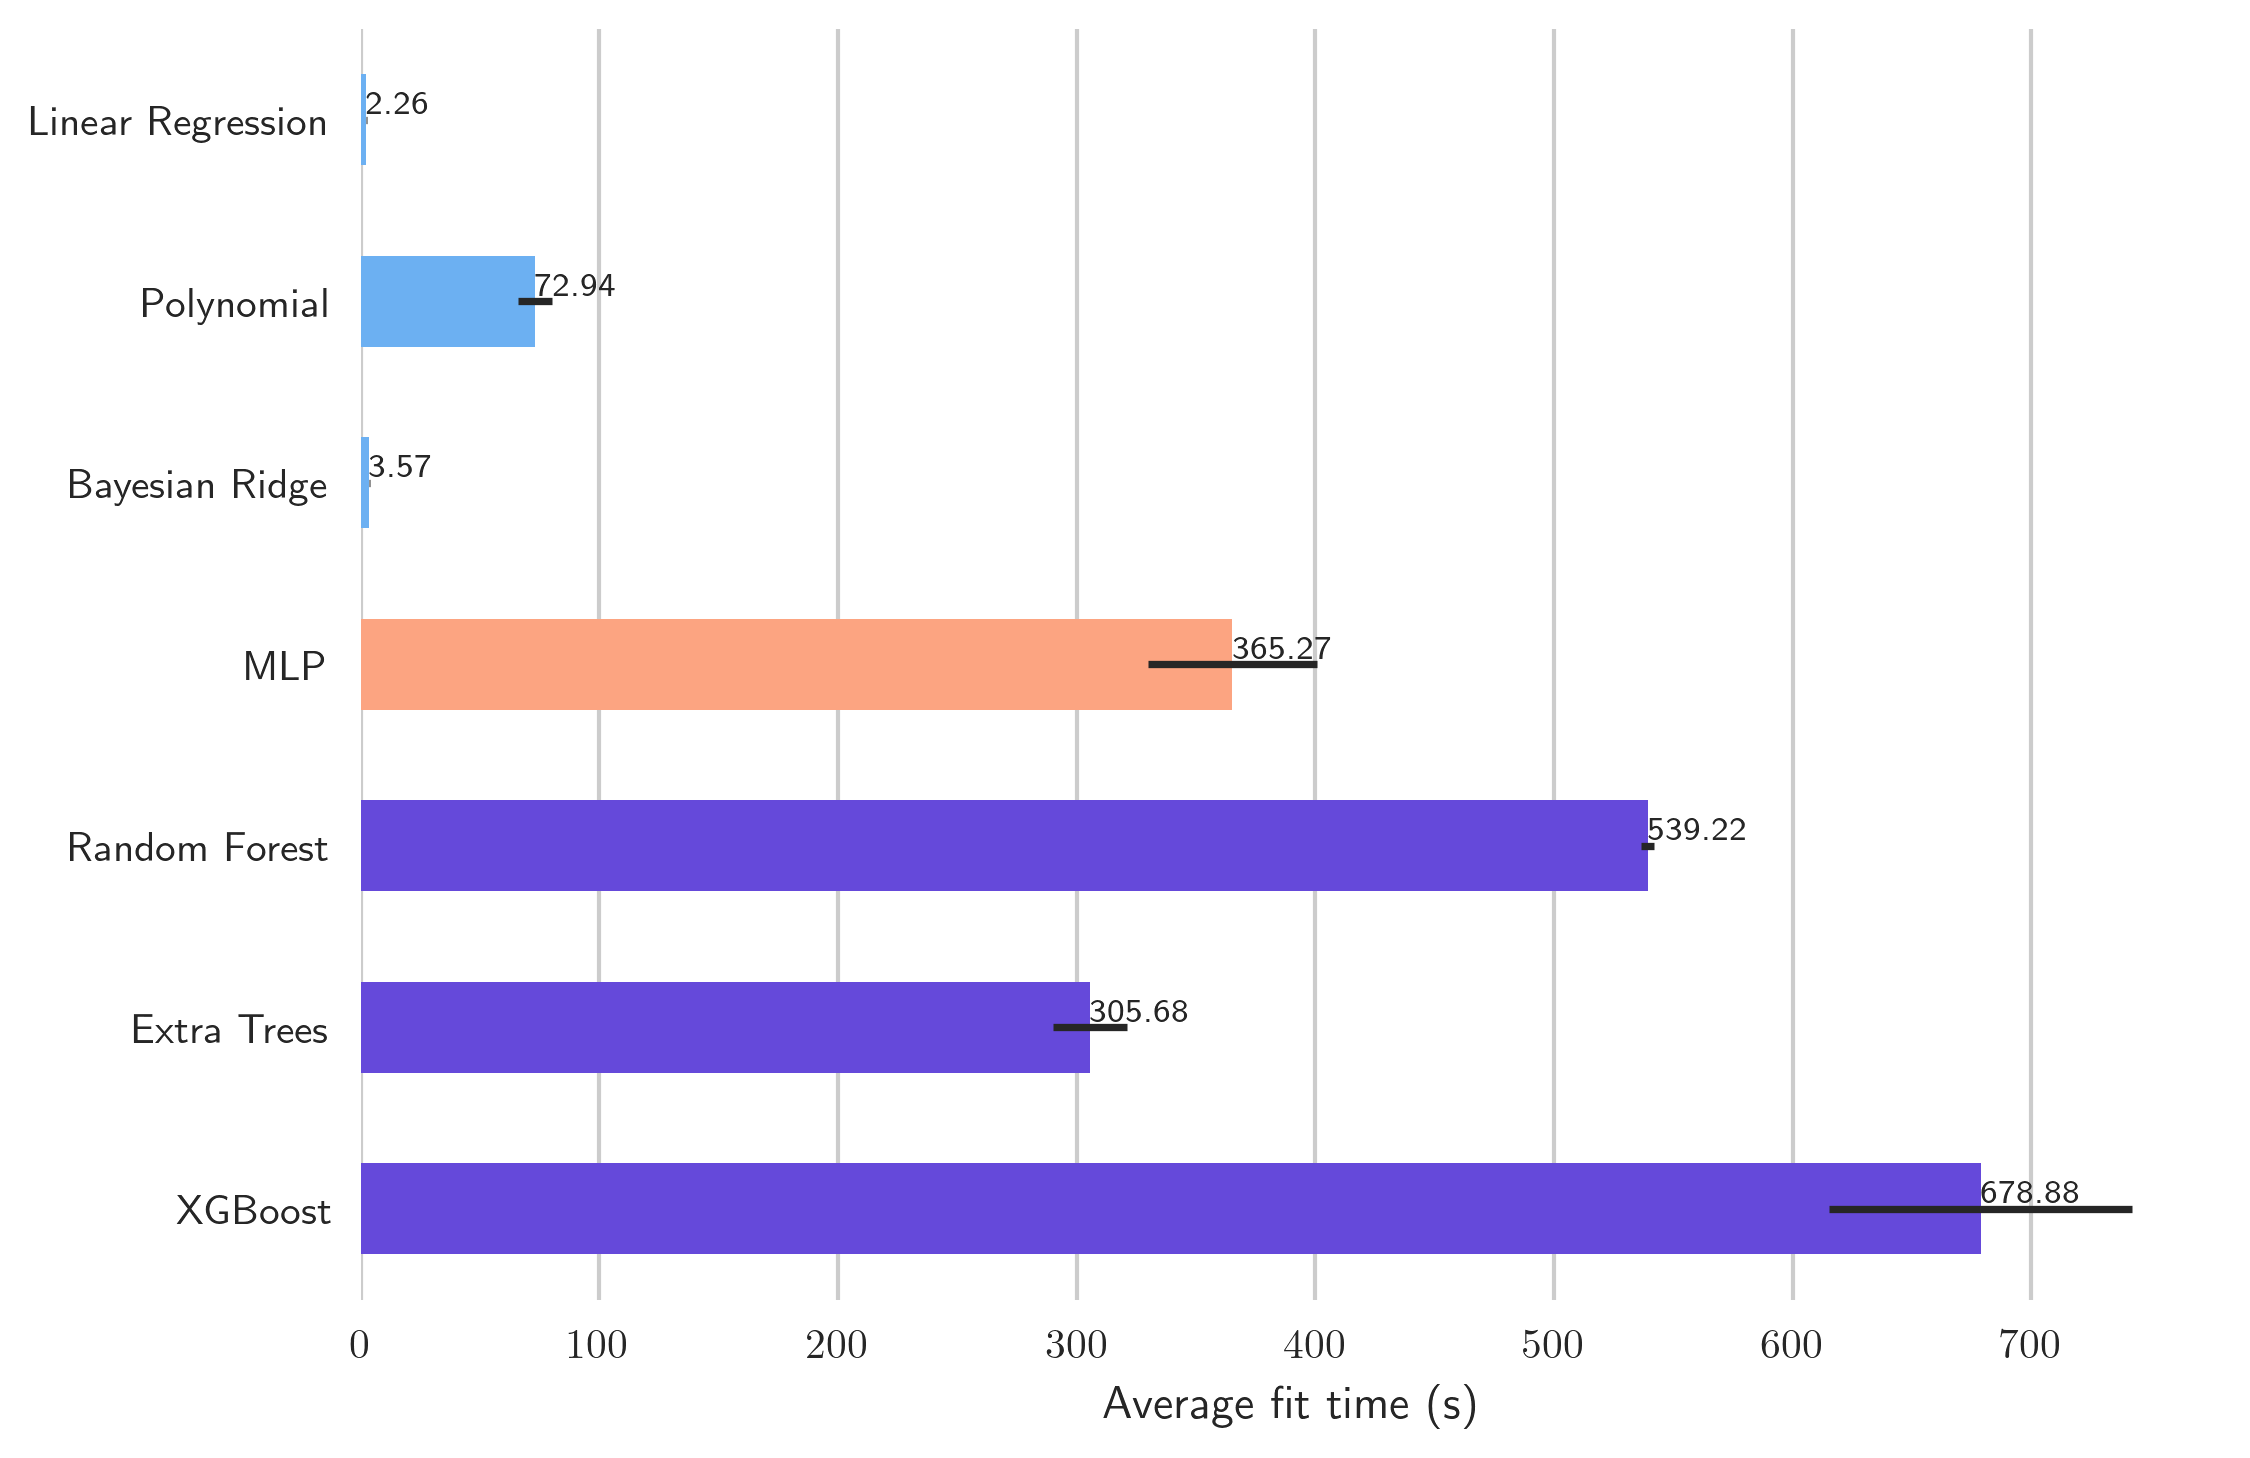

In [46]:
fig, ax = plt.subplots(dpi=300)

fit_df.plot(kind = "barh", y = "Fit Time", 
            legend = False, 
#             title = "Average Fit Times", 
            xerr = "Error", color=colors,
            ax=ax)


for patch in ax.patches:
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{patch.get_width():0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
ax.invert_yaxis()
ax.set_xlabel('Average fit time (s)')
ax.spines[:].set_visible(False)

ax.grid(False, axis='y')

fig.savefig(f'{save_path}/fit_times-all_years.png', format='png', bbox_inches = "tight")